<a href="https://colab.research.google.com/github/hamed-RM/NN-hyper-parameters-optimization-by-GA/blob/main/77_5_on_ferplus_and_ckplus_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# os.mkdir('data')
!unzip "drive/MyDrive/data/ckplus.zip" -d ./data/
# !unzip "drive/MyDrive/data/jaffe.zip" -d ./data/
!unzip "drive/MyDrive/data/ferplus.zip" -d ./data/
!unzip "drive/MyDrive/data/affect net.zip" -d ./data/




Archive:  drive/MyDrive/data/ckplus.zip
  inflating: ./data/ckplus.csv       
Archive:  drive/MyDrive/data/ferplus.zip
  inflating: ./data/ferplus.csv      
Archive:  drive/MyDrive/data/affect net.zip
  inflating: ./data/affect net.csv   


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## imports

In [ ]:
pip install mtcnn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 9.8 MB/s eta 0:00:00


In [ ]:
import cv2
# from pytorchyolo import detect,models
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pandas as pd
import numpy as np
# import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms,RandomRotation,ColorJitter,GaussianBlur,RandomHorizontalFlip,Resize
import torchvision
from typing import Type as t_type
from torch import Tensor
import torch.nn.functional as F
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from mtcnn.mtcnn import MTCNN
# device = torch.device('cpu')
from torch.utils.data.sampler import WeightedRandomSampler
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [ ]:
detector = MTCNN()
def get_face_mtcnn(image):
    """
    return faces detected im image.result is (48,48) in gray scale.

    Parameters
    ----------
    - image(nd array):gray scale image.

    Returns
    -------
    - faces(list):a list includes faces in image.
    """

    img_size=48
    image=cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    # Detect faces in the image
    faces = detector.detect_faces(image)
    cropped_face=[]
    # Loop through each detected face and crop it
    for face in faces:
        x, y, w, h = face['box']

        # You can adjust the cropping region as needed
        margin = 0
        x -= margin
        y -= margin
        w += 2 * margin
        h += 2 * margin

        # Ensure the cropping region is within the image boundaries
        x = max(0, x)
        y = max(0, y)
        w = min(w, image.shape[1])
        h = min(h, image.shape[0])

        # Crop the face
        # print(f'{cv2.resize(image[y:y+h, x:x+w], (48, 48))[:,:,0].shape=}')
        cropped_face.append((cv2.cvtColor(cv2.resize(image[y:y+h, x:x+w], (img_size, img_size)),cv2.COLOR_RGB2GRAY),(x,y,w,h)))
    print(f'{len(cropped_face)=}')
    # for face in cropped_face:
    #     plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    #     plt.show()
    return cropped_face

In [ ]:
def plot_matrix(y,y_pred,plot_name):
    cm=confusion_matrix(y_pred,y)

    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=np.unique(y),
                yticklabels=np.unique(y))
    accuracy=sum(y==y_pred)/len(y)
    # print(f'{accuracy=}')
    plt.ylabel('Prediction',fontsize=13)
    plt.xlabel('Actual',fontsize=13)
    plt.title(plot_name,fontsize=17)
    plt.savefig(plot_name+'.jpg')
    plt.show()
    return accuracy




def plot_tensor(tensor:Tensor):
    # print(tensor.shape)
    image_np = tensor.squeeze().cpu().numpy()
    # print(image_np.shape)

    # Display the image using Matplotlib
    fig, ax = plt.subplots(figsize=(224/100, 224/100), dpi=100)  # Adjust dpi as needed

    # Display the image without any additional border or padding
    ax.imshow(image_np, cmap='gray', interpolation='none')
    # ax.set_xlim(0, 224)
    # ax.set_ylim(0, 224)
    ax.axis('off')  # Turn off axis labels and ticks

    # Save the image without additional border or padding
    # plt.savefig("saved_image.png", bbox_inches='tight', pad_inches=0, dpi=100)
    plt.show()

def resize_tensor(img,size:int)->Tensor:
    # print(tensor.shape)
    # target_size = (size, size)

    # resized_tensor = F.interpolate(tensor, size=target_size, mode='bilinear', align_corners=False)
    # print(resized_tensor.shape)

    resized_image = cv2.resize(img, (size, size))

    return resized_image
class CustomDataset(Dataset):
    def __init__(self, imgs, combined_lbls, transform=None):
        emotion_lbls=[]
        coarse_lbls=[]
        fine_lbls=[]
        for lbl in combined_lbls:
            e,c,f=[int(t) for t in lbl.split('_')]
            # print(e,c,f)
            emotion_lbls.append(e)
            coarse_lbls.append(c)
            fine_lbls.append(f)

        print(f'{imgs.shape=},{len(emotion_lbls)=},{len(coarse_lbls)=},{len(fine_lbls)=}')

        coarse_lbls=torch.tensor(coarse_lbls, dtype=torch.float16)
        coarse_lbls=nn.functional.one_hot(coarse_lbls.to(torch.int64), num_classes=4)
        coarse_lbls=coarse_lbls.to(torch.float16)

        fine_lbls=torch.tensor(fine_lbls, dtype=torch.float16)
        fine_lbls=nn.functional.one_hot(fine_lbls.to(torch.int64), num_classes=2)
        fine_lbls=fine_lbls.to(torch.float16)

        emotion_lbls=torch.tensor(emotion_lbls, dtype=torch.float16)

        self.imgs = imgs
        self.emotion_lbls = emotion_lbls
        self.coarse_lbls = coarse_lbls
        self.fine_lbls = fine_lbls
        self.transform = transform
        # self.targets = emotion_lbls

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # print(f'{idx=}')
        img,emotion_lbl, coarse_lbl, fine_lbl = self.imgs[idx], self.emotion_lbls[idx],self.coarse_lbls[idx], self.fine_lbls[idx]
        img=Image.fromarray(img)
        img=img = self.transform(img)

        return img,emotion_lbl, coarse_lbl, fine_lbl

def string_to_array(x):
    result=np.array(x.split(' '),dtype=np.uint8).reshape(48,48)
    return result



In [ ]:
def get_dataloaders(dfs_names,batch_size):

    dfs=[]

    for d in dfs_names:
        dfs.append(pd.read_csv(f'./data/{d}.csv'))
    df=pd.concat(dfs,axis=0,ignore_index=True)
    condition=df['emotion']==7
    df=df[~condition]

    X = np.array(df['pixels'].apply(lambda x: string_to_array(x)).tolist())
    # X=np.array(X)
    print(X.shape)
    # X=X.reshape((-1,48,48))
    # X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    # X=(X-X.min())/(X.max()-X.min())

    y_coarse=np.array(df['coarse']).astype(np.uint8)

    y_fine=np.array(df['fine']).astype(np.uint8)

    y_emotion=df['emotion'].astype(np.uint8)


    combined_lbls=[f'{e}_{c}_{f}' for e,c,f in zip (y_emotion,y_coarse,y_fine)]

    x_train, x_valid, y_train_combined, y_valid_combined = train_test_split(X, combined_lbls, test_size=0.2, train_size=0.8, random_state=7,
                                                        shuffle=True,stratify=combined_lbls)

    img_size=100
    train_transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomApply([transforms.RandomRotation(degrees=(0, 10))], p=0.1),
        Resize((img_size,img_size)),
        # transforms.RandomApply([transforms.ColorJitter(brightness=0.1)], p=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),

    ])
    valid_transform = transforms.Compose([
                Resize((img_size,img_size)),
                transforms.ToTensor(),  # Convert to PyTorch tensor
                transforms.Normalize(mean=[0.5], std=[0.5])
                ])



    dataset_train = CustomDataset(x_train,y_train_combined,transform=train_transform)
    dataset_valid = CustomDataset(x_valid, y_valid_combined,transform=valid_transform)

    train_unique_values, train_unique_counts=torch.unique(dataset_train.emotion_lbls,return_counts=True)
    train_class_weights = 1.0 /train_unique_counts
    train_weights = torch.tensor([train_class_weights[int(label)] for label in dataset_train.emotion_lbls])
    train_sampler = WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler, pin_memory=True)

    # valid_unique_values, valid_unique_counts=torch.unique(dataset_valid.emotion_lbls,return_counts=True)
    # valid_class_weights = 1.0 /valid_unique_counts
    # valid_weights = torch.tensor([valid_class_weights[int(label)] for label in dataset_valid.emotion_lbls])
    # valid_sampler = WeightedRandomSampler(valid_weights, num_samples=len(valid_weights), replacement=True)
    # dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, sampler=valid_sampler, pin_memory=True)


    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True)
    return dataloader_train , dataloader_valid

In [ ]:
import torch
import torch.nn as nn

class CoarseClassifier(nn.Module):

    def __init__(self, num_classes):

        super(CoarseClassifier,self).__init__()

        # First set of convolutional layers
        self.drop1=nn.Dropout2d(0.1)
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=3)


        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flt = nn.Flatten()
        # Fully connected layer
        self.fc1 = nn.Linear(64*3*3, 512)
        self.sigmoid1 = nn.Sigmoid()

        self.fc2 = nn.Linear(512, 128)
        self.sigmoid2 = nn.Sigmoid()

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First set of convolutional layers
        x = self.drop1(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # print(f'{x.shape=}')
        self.o_corase=x.clone()
        # Flatten and pass through fully connected layer
        x = self.flt(x)
        # print(f'after flatten{x.shape[1]}=')
        x = self.fc1(x)
        x = self.sigmoid1(x)

        x = self.fc2(x)
        x = self.sigmoid2(x)

        x = self.fc3(x)

        return x
    def get_o_coarse(self):
        return self.o_corase


def train_step_coarse(model,num_epochs,dataloader_train,dataloader_valid):
    acc_train=[]
    acc_valid=[]

    model.train()
    for epoch in range(num_epochs):

        if epoch in [2*num_epochs//3]:
            for param_group in optimizer.param_groups:
                param_group['lr']/=10

        print('epoch:',epoch)
        total=0
        correct=0
        for x,_,y,_ in dataloader_train:
            # print(f'train {x.shape=}')
            x,y=x.to(device),y.to(device)

            outputs = model(x)
            loss = criterion(outputs, y)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,predicted=torch.max(outputs.data,1)
            total+=y.size(0)
            correct+=(predicted==torch.argmax(y,dim=1)).sum()

        print(f'training:accuracy:{(100*correct/total):.2f}%')
        acc_train.append((100*correct/total))


        model.eval()
        with torch.no_grad():
            total=0
            correct=0
            for x,_,y,_ in dataloader_valid:
                # print(f'test {x.shape=}')

                x,y=x.to(device),y.to(device)

                outputs = model(x)

                _,predicted=torch.max(outputs.data,1)
                total+=y.size(0)

                correct+=(predicted==torch.argmax(y,dim=1)).sum()

            print(f'test:accuracy:{(100*correct/total):.2f}%')
            acc_valid.append((100*correct/total))

            # plt.close()
            plt.plot(torch.tensor(list(range(epoch+1)),dtype=torch.float32).cpu().numpy(),
                     torch.tensor(acc_train,dtype=torch.float32).cpu().numpy(), 'bo', label='Training Accuracy')
            plt.plot(torch.tensor(list(range(epoch+1)),dtype=torch.float32).cpu().numpy(),
                     torch.tensor(acc_valid,dtype=torch.float32).cpu().numpy(), 'b', label='Validation Accuracy')
            plt.title(f'Coarse classifier Training and Validation Accuracy\n lr:{optimizer.param_groups[0]["lr"]:.2e}, batch_size:{batch_size}')
            plt.legend()
            plt.show()
            print('***********---------------************')



In [ ]:
class SubFineClassifier(nn.Module):
    def __init__(self, num_classes):
        super(SubFineClassifier, self).__init__()

        self.conv1 = nn.Conv2d(64, 16, kernel_size=2, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)


        # self.conv2 = nn.Conv2d(16, 8, kernel_size=2, stride=2, padding=1)
        # self.bn2 = nn.BatchNorm2d(8)
        # self.relu2 = nn.ReLU(inplace=True)
        # self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flt = nn.Flatten()

        self.fc1 = nn.Linear(16*2*2, 64)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # x = self.conv2(x)
        # x = self.bn2(x)
        # x = self.relu2(x)
        # x = self.maxpool2(x)

        # print(f'{x.shape=}')

        x = self.flt(x)
        # print(f'{x.shape=}')
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.fc2(x)

        return x

class FineClassifier(nn.Module):
    def __init__(self, fine_classes, coarse_model):
        super(FineClassifier, self).__init__()

        for param in coarse_model.parameters():
            param.requires_grad = False

        self.sub_fine_classifiers = nn.ModuleDict()
        for fine_class in fine_classes:
            self.sub_fine_classifiers[fine_class] = SubFineClassifier(fine_classes[fine_class])

    def forward(self, x,y_coarse):
        coarse_model.eval()
        with torch.no_grad():
            coarse_output = coarse_model(x)
            # coarse_categories = torch.argmax(coarse_output, dim=1)
        fine_outputs = []
        coarse_categories=torch.argmax(y_coarse, dim=1)
        # print(coarse_categories.shape,coarse_categories)
        for ind, coarse_category in enumerate(coarse_categories):
            if coarse_category==3:
                fine_outputs.append(torch.tensor([[1.0,0]]).to(device))
                continue
            fine_classifier = self.sub_fine_classifiers[str(coarse_category.tolist())]
            fine_output = fine_classifier(coarse_model.get_o_coarse()[ind].unsqueeze(0))  # Unsqueeze to add batch dimension
            # print(f'{fine_output.tolist()=}')
            # if len(fine_output.tolist()[0]) < 1:
            #      fine_output=torch.cat((fine_output, torch.tensor([[-float('inf')]]).to(device)), dim=1).to(device)
            # fine_output=torch.cat((fine_output, torch.tensor([[-float('inf')]]).to(device)), dim=1).to(device)

            fine_outputs.append(fine_output)
        # print(f'{fine_outputs=}')
        fine_outputs = torch.cat(fine_outputs, dim=0).to(device)
        # print(f'{fine_outputs=}')

        return fine_outputs

def train_step_fine(model,num_epochs,dataloader_train,dataloader_valid):
    acc_train=[]
    acc_valid=[]

    model.train()
    for epoch in range(num_epochs):
        if epoch in [2*num_epochs//3]:
            for param_group in optimizer.param_groups:
                param_group['lr']/=10
        print('epoch:',epoch)
        total=0
        correct=0
        for x,_,y_coarse,y in dataloader_train:
            x,y_coarse,y=x.to(device),y_coarse.to(device),y.to(device)

            # Forward pass
            outputs = model(x,y_coarse)
            # print(outputs)
            # print(y)
            loss = criterion(outputs, y)

            # Zero gradients, backward pass, and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,predicted=torch.max(outputs.data,1)
            total+=y.size(0)
            correct+=(predicted==torch.argmax(y,dim=1)).sum()
            # print(f'{(correct/total):.2f}%')
        # Print loss for monitoring training progress
        # print(f'training:\nEpoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()/total},\naccuracy:{(100*correct/total):.2f}%')
        print(f'training:accuracy:{(100*correct/total):.2f}%')
        acc_train.append((100*correct/total))

        # for param_group in optimizer.param_groups:
        #     param_group['lr']*=0.99



        model.eval()
        with torch.no_grad():
            total=0
            correct=0
            for x,_,y_coarse,y in dataloader_valid:

                x,y_coarse,y=x.to(device),y_coarse.to(device),y.to(device)
                # Forward pass
                outputs = model(x,y_coarse)
                # outputs=[str(i) for i in outputs ]
                # outputs='_'.join(outputs)
                ## arg max in both coarse and fine

                # Zero gradients, backward pass, and optimization step
                _,predicted=torch.max(outputs.data,1)
                total+=y.size(0)

                correct+=(predicted==torch.argmax(y,dim=1)).sum()
                # print(f'{(correct/total):.2f}%')
            # Print loss for monitoring training progress
            print(f'test:accuracy:{(100*correct/total):.2f}%')
            acc_valid.append((100*correct/total))
            # print(torch.tensor(list(range(epoch)),dtype=torch.float32).cpu().numpy().shape)
            # print(torch.tensor(acc_train,dtype=torch.float32).cpu().numpy().shape)
            plt.close()
            plt.plot(torch.tensor(list(range(epoch+1)),dtype=torch.float32).cpu().numpy(),
                     torch.tensor(acc_train,dtype=torch.float32).cpu().numpy(), 'bo', label='Training Accuracy')
            plt.plot(torch.tensor(list(range(epoch+1)),dtype=torch.float32).cpu().numpy(),
                     torch.tensor(acc_valid,dtype=torch.float32).cpu().numpy(), 'b', label='Validation Accuracy')
            plt.title(f'Fine classifier Training and Validation Accuracy\n lr:{optimizer.param_groups[0]["lr"]:.2e}, batch_size:{batch_size}')
            plt.legend()
            plt.show()
            print()
            # if acc_train[-1] > 95 and acc_valid[-1] > 94:
            #     return


In [ ]:
class_count={int(key):0 for key in train_unique_values}
for batch_idx, (images,emotions,coarses,fines) in enumerate(dataloader_train):
    # print(f'{imgs[0]=}\n{emotions[0]=}\n{coarses[0]=}\n{fines[0]=}')
    for e in emotions:
        class_count[int(e)]+=1
class_count

{0: 5486, 1: 5498, 2: 5447, 3: 5618, 4: 5373, 5: 5515, 6: 5547}

In [ ]:
dfs_names=['affect net']
batch_size = 32
dataloader_train , dataloader_valid = get_dataloaders(dfs_names,batch_size)

(24320, 48, 48)
imgs.shape=(19456, 48, 48),len(emotion_lbls)=19456,len(coarse_lbls)=19456,len(fine_lbls)=19456
imgs.shape=(4864, 48, 48),len(emotion_lbls)=4864,len(coarse_lbls)=4864,len(fine_lbls)=4864


epoch: 0
training:accuracy:37.46%
test:accuracy:45.52%


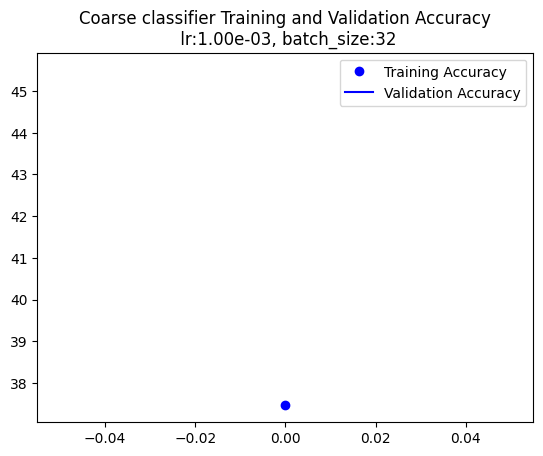

***********---------------************
epoch: 1
training:accuracy:48.97%
test:accuracy:51.07%


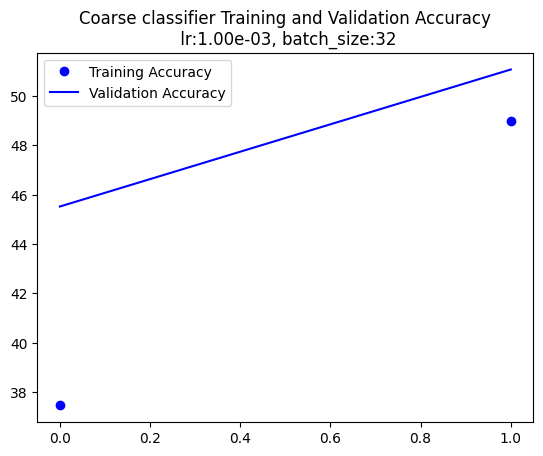

***********---------------************
epoch: 2
training:accuracy:54.39%
test:accuracy:58.00%


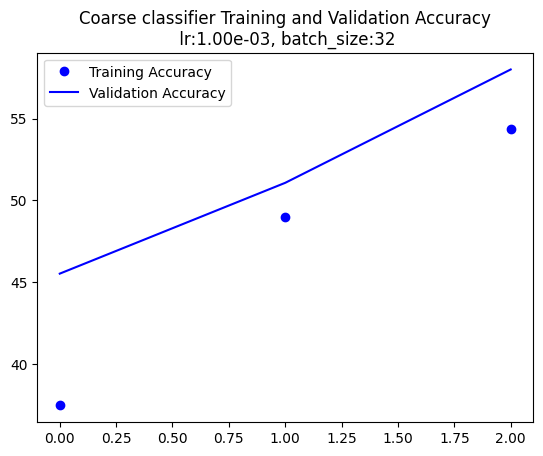

***********---------------************
epoch: 3
training:accuracy:56.40%
test:accuracy:57.61%


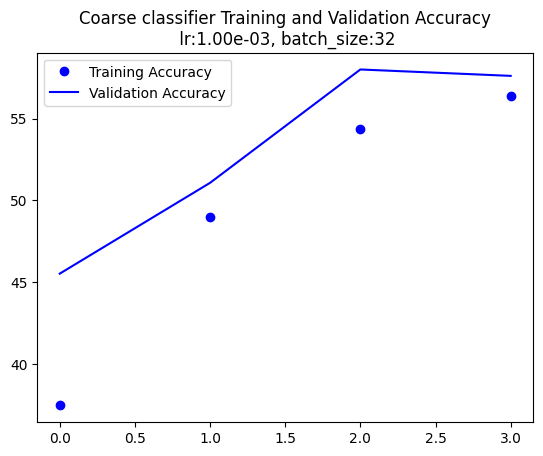

***********---------------************
epoch: 4
training:accuracy:58.38%
test:accuracy:54.21%


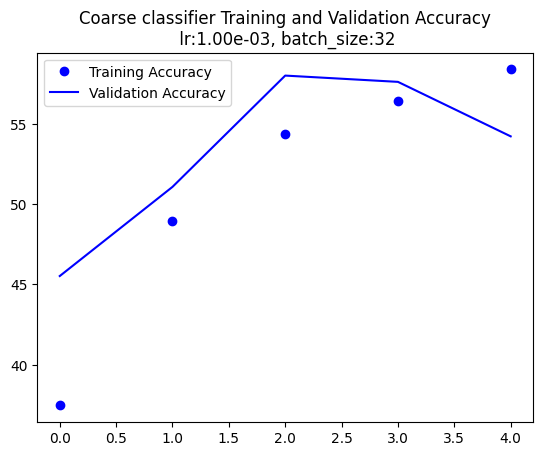

***********---------------************
epoch: 5
training:accuracy:59.12%
test:accuracy:60.05%


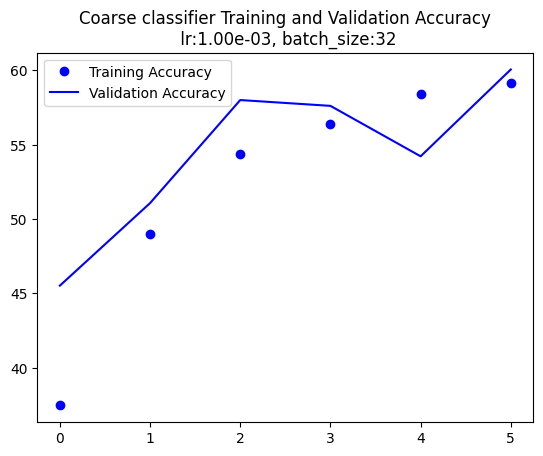

***********---------------************
epoch: 6
training:accuracy:60.46%
test:accuracy:58.96%


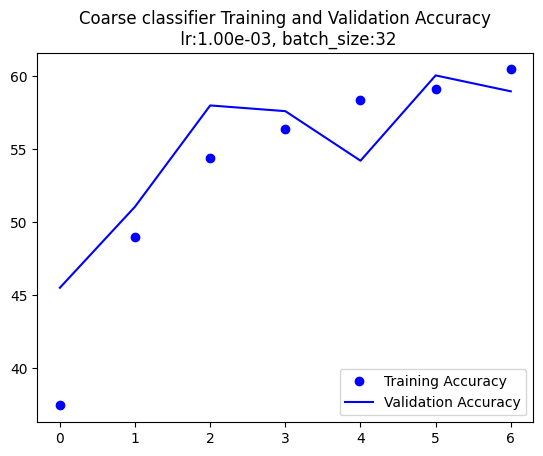

***********---------------************
epoch: 7
training:accuracy:60.80%
test:accuracy:61.27%


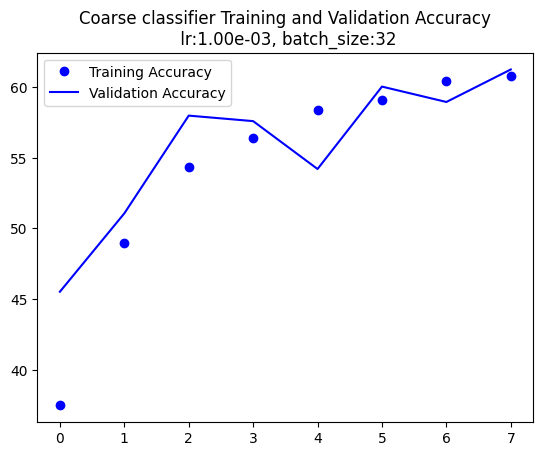

***********---------------************
epoch: 8
training:accuracy:61.39%
test:accuracy:59.19%


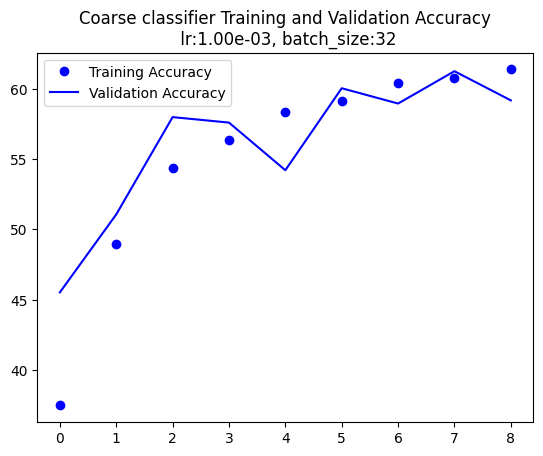

***********---------------************
epoch: 9
training:accuracy:62.44%
test:accuracy:61.20%


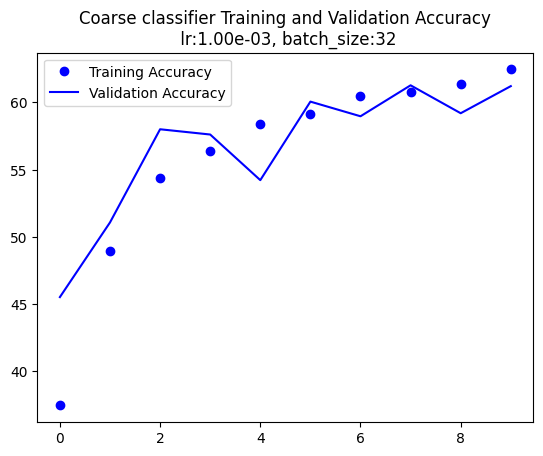

***********---------------************
epoch: 10
training:accuracy:63.33%
test:accuracy:62.05%


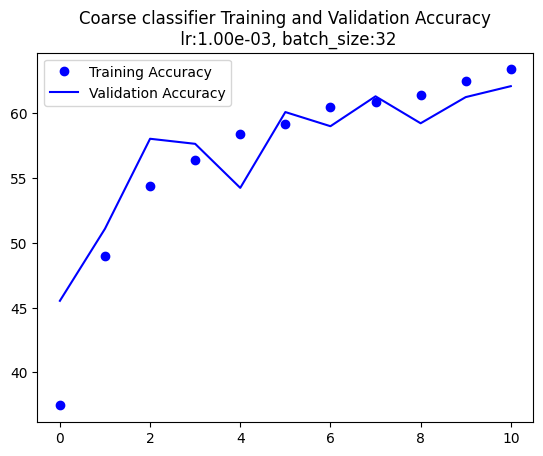

***********---------------************
epoch: 11
training:accuracy:63.11%
test:accuracy:62.56%


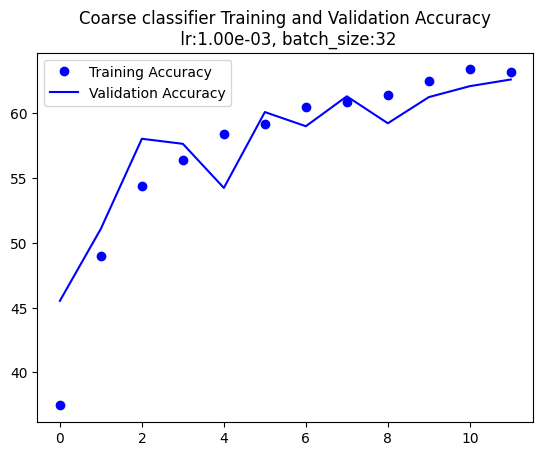

***********---------------************
epoch: 12
training:accuracy:64.55%
test:accuracy:62.95%


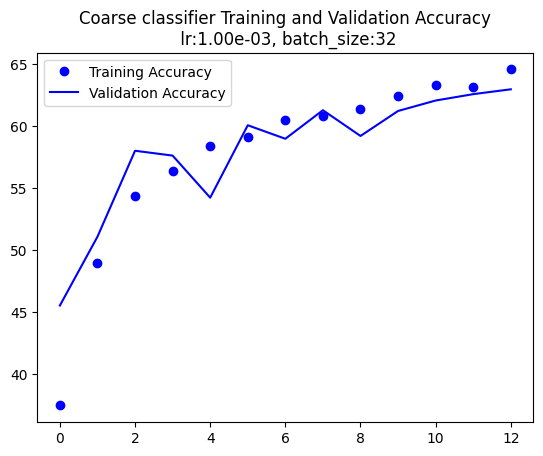

***********---------------************
epoch: 13
training:accuracy:64.74%
test:accuracy:62.77%


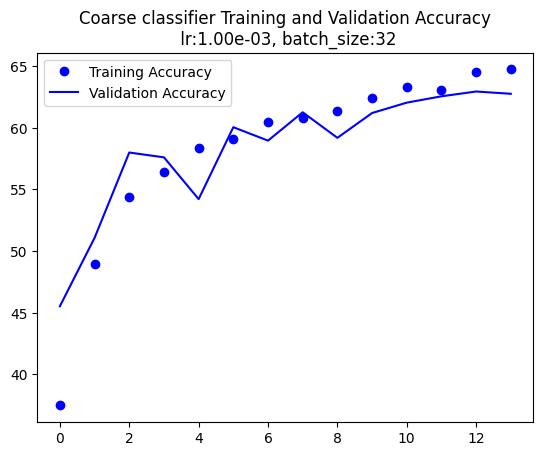

***********---------------************
epoch: 14
training:accuracy:64.73%
test:accuracy:63.12%


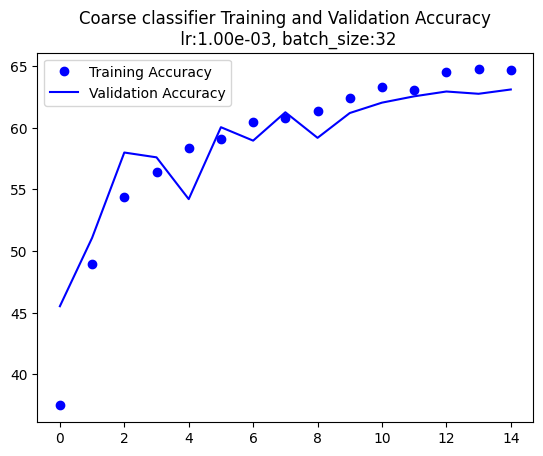

***********---------------************
epoch: 15
training:accuracy:65.74%
test:accuracy:55.55%


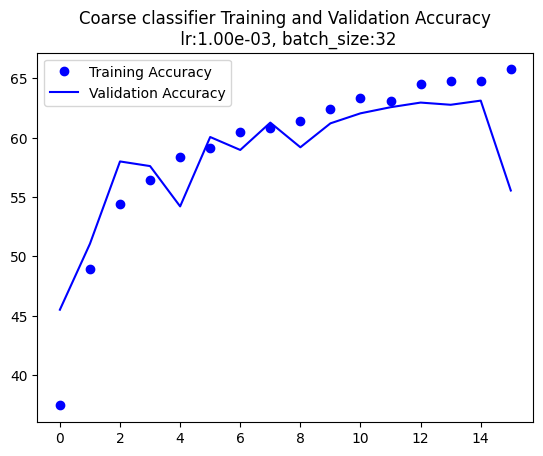

***********---------------************
epoch: 16
training:accuracy:65.21%
test:accuracy:62.48%


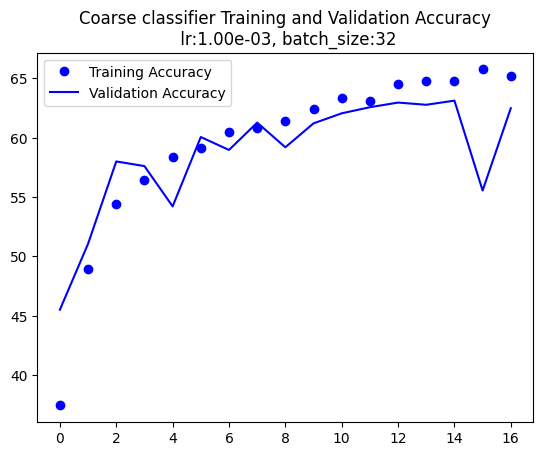

***********---------------************
epoch: 17
training:accuracy:66.77%
test:accuracy:59.58%


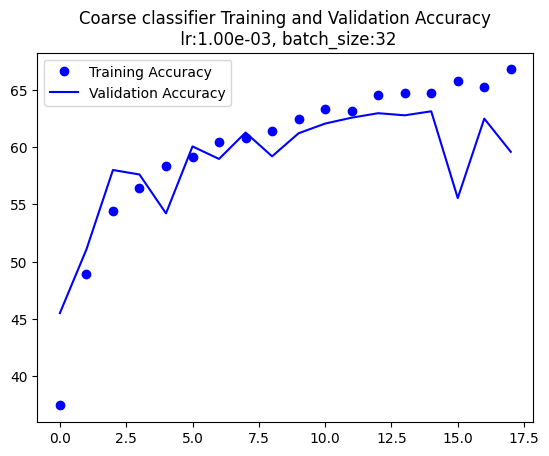

***********---------------************
epoch: 18
training:accuracy:65.61%
test:accuracy:61.64%


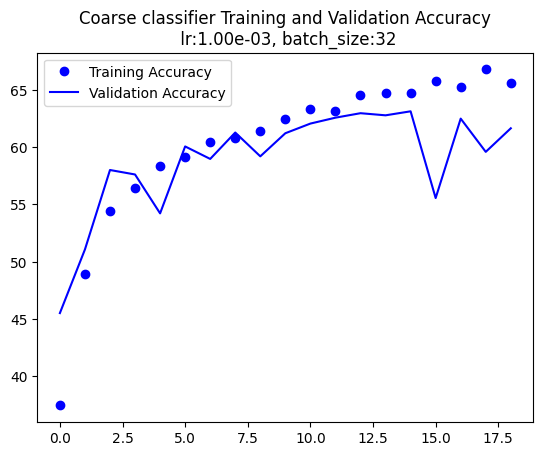

***********---------------************
epoch: 19
training:accuracy:67.12%
test:accuracy:63.71%


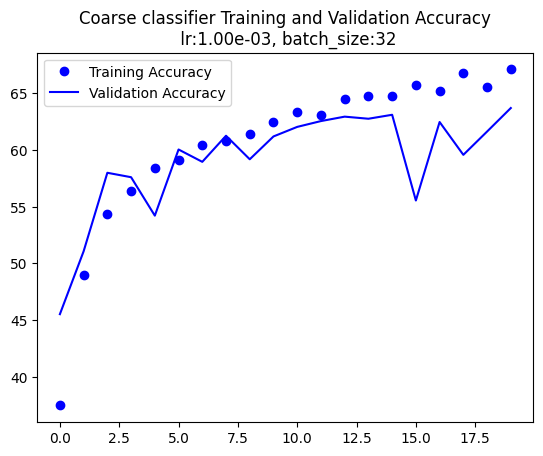

***********---------------************
epoch: 20
training:accuracy:67.12%
test:accuracy:62.38%


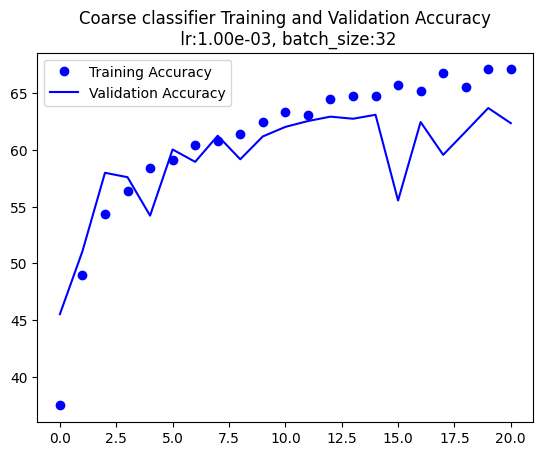

***********---------------************
epoch: 21
training:accuracy:67.82%
test:accuracy:63.65%


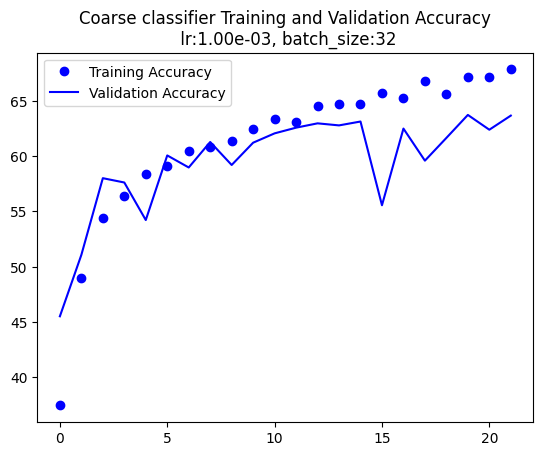

***********---------------************
epoch: 22
training:accuracy:67.80%
test:accuracy:60.44%


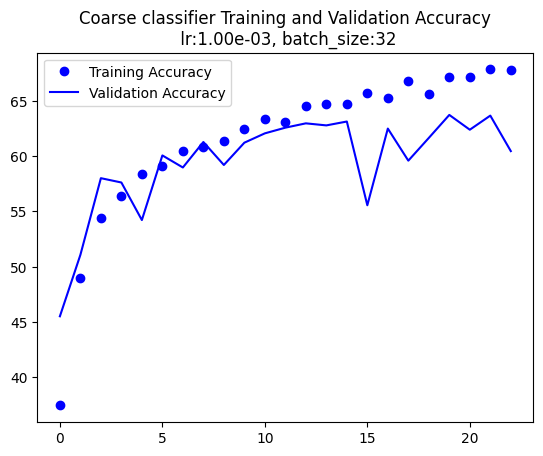

***********---------------************
epoch: 23
training:accuracy:67.92%
test:accuracy:63.51%


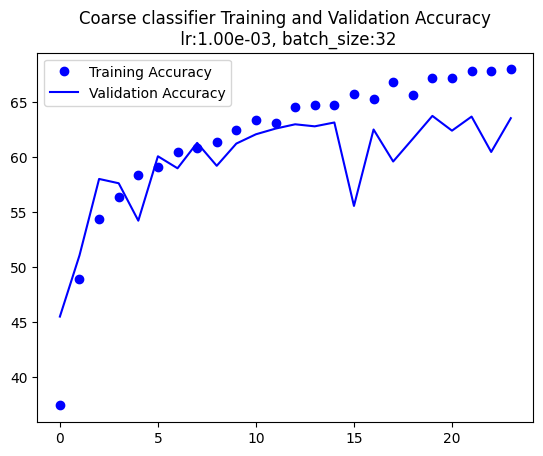

***********---------------************
epoch: 24
training:accuracy:68.33%
test:accuracy:59.75%


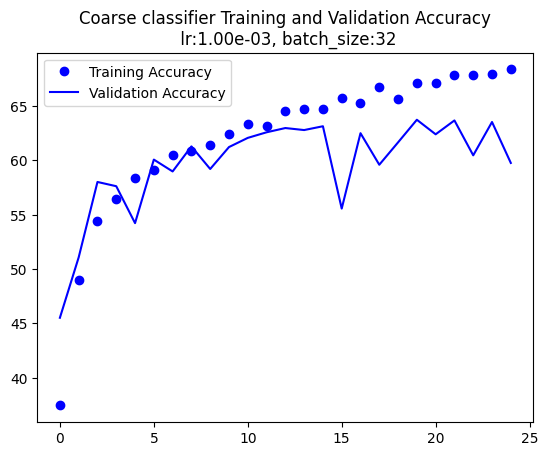

***********---------------************
epoch: 25
training:accuracy:68.74%
test:accuracy:62.97%


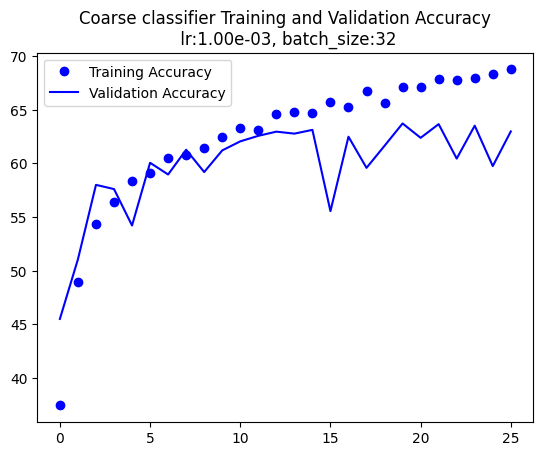

***********---------------************
epoch: 26
training:accuracy:69.23%
test:accuracy:62.73%


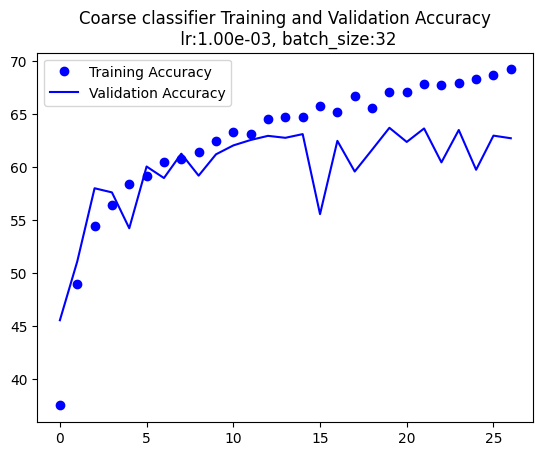

***********---------------************
epoch: 27
training:accuracy:69.35%
test:accuracy:63.71%


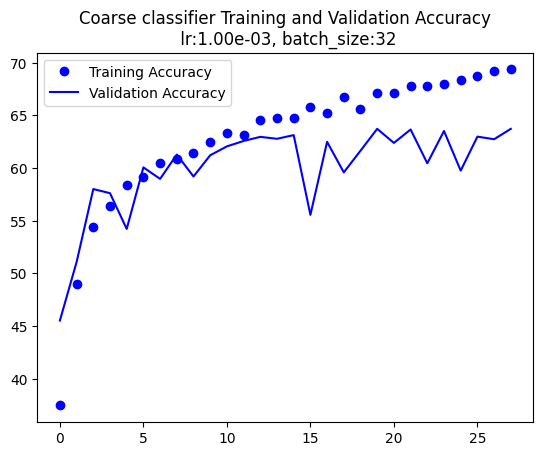

***********---------------************
epoch: 28
training:accuracy:69.91%
test:accuracy:63.88%


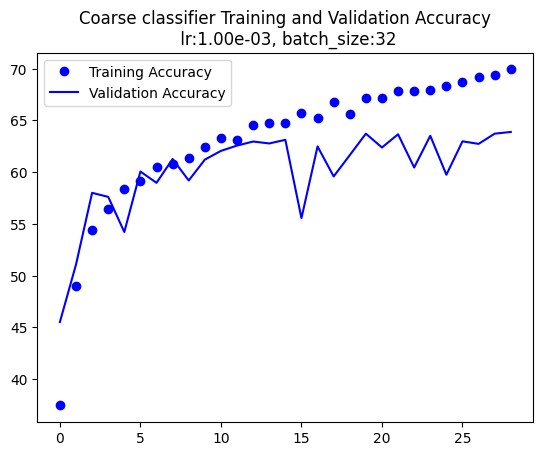

***********---------------************
epoch: 29
training:accuracy:70.61%
test:accuracy:62.09%


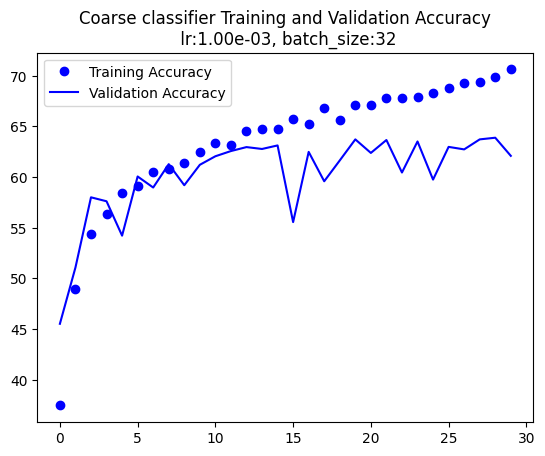

***********---------------************
epoch: 30
training:accuracy:70.32%
test:accuracy:62.50%


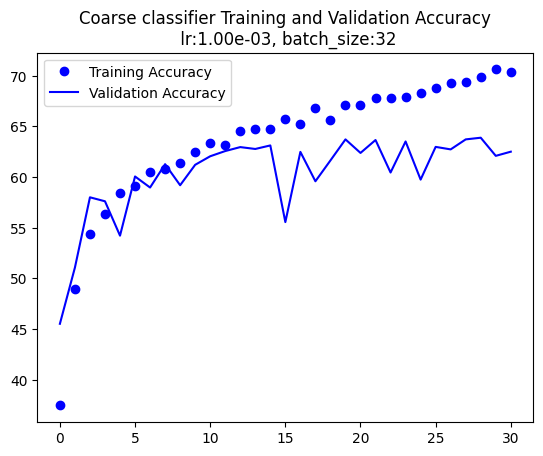

***********---------------************
epoch: 31
training:accuracy:70.54%
test:accuracy:61.97%


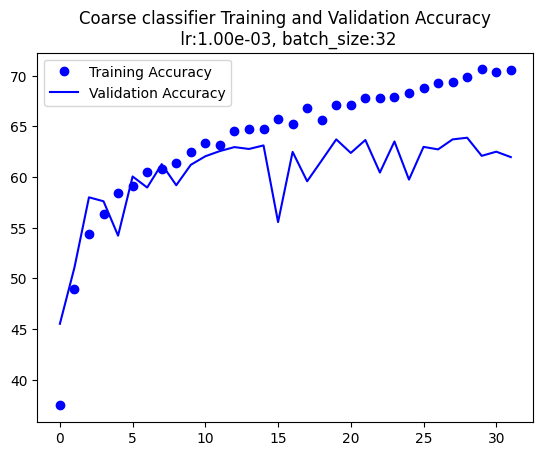

***********---------------************
epoch: 32
training:accuracy:70.85%
test:accuracy:62.01%


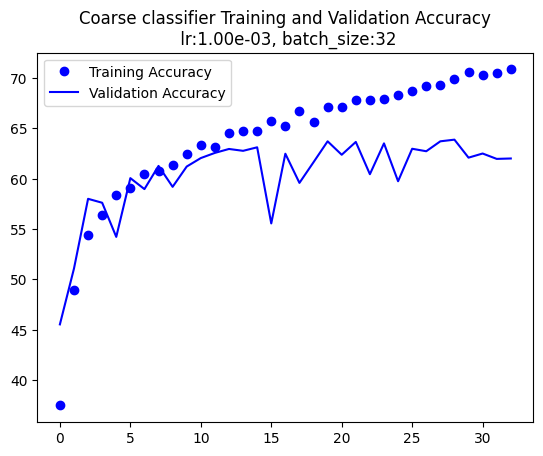

***********---------------************
epoch: 33
training:accuracy:71.60%
test:accuracy:63.38%


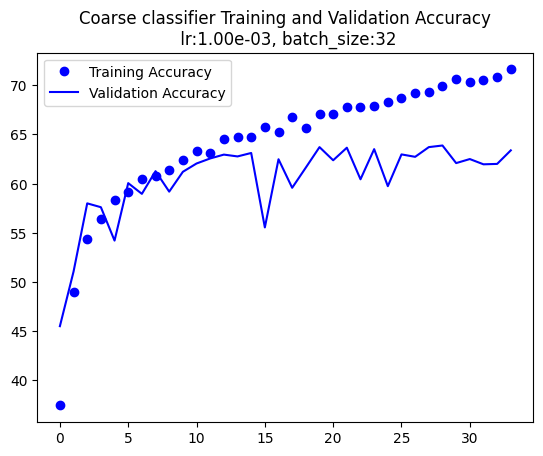

***********---------------************
epoch: 34
training:accuracy:71.82%
test:accuracy:62.46%


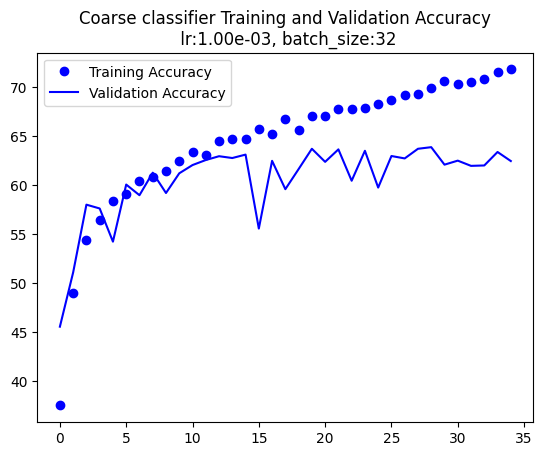

***********---------------************
epoch: 35
training:accuracy:71.53%
test:accuracy:63.22%


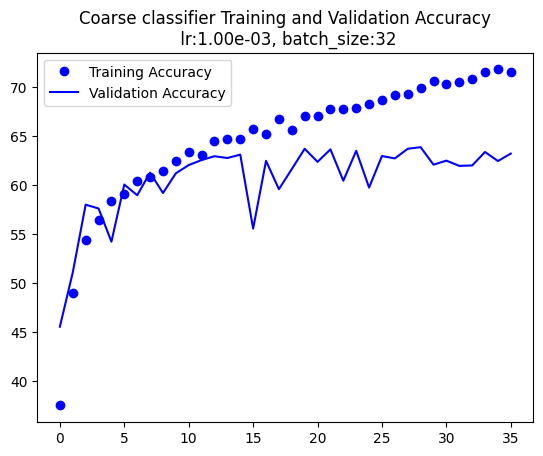

***********---------------************
epoch: 36
training:accuracy:71.64%
test:accuracy:61.84%


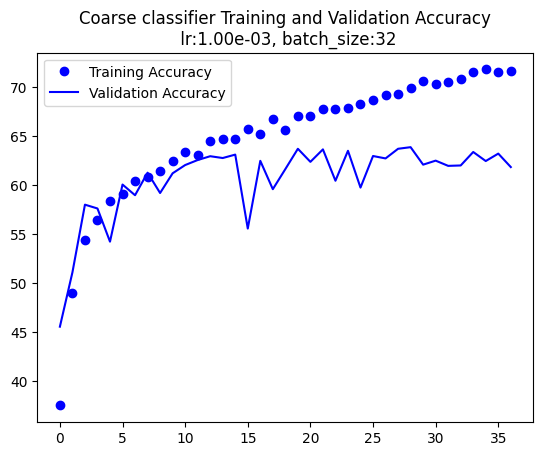

***********---------------************
epoch: 37
training:accuracy:71.73%
test:accuracy:63.01%


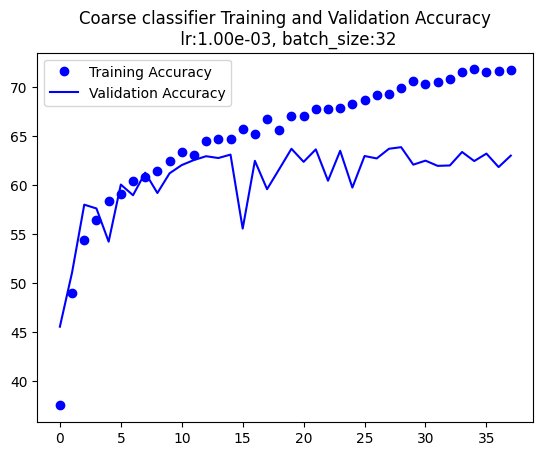

***********---------------************
epoch: 38
training:accuracy:72.83%
test:accuracy:63.22%


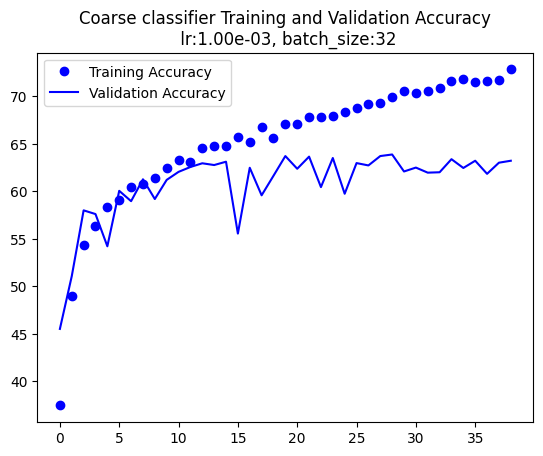

***********---------------************
epoch: 39
training:accuracy:72.45%
test:accuracy:61.47%


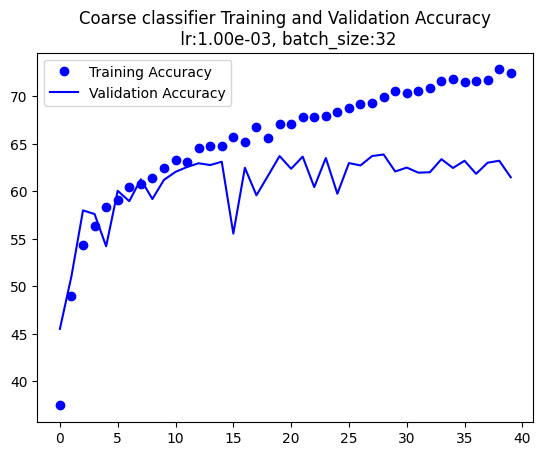

***********---------------************
epoch: 40
training:accuracy:72.51%
test:accuracy:61.76%


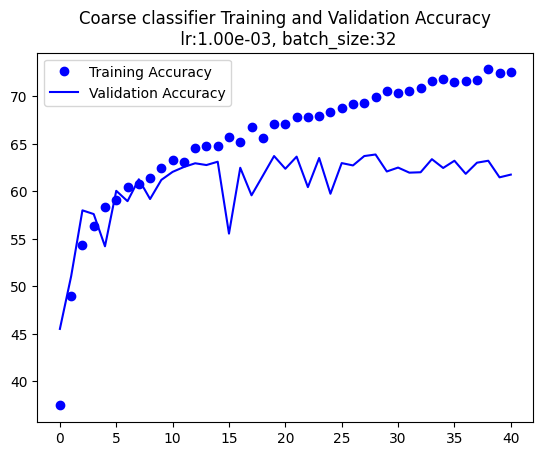

***********---------------************
epoch: 41
training:accuracy:72.85%
test:accuracy:62.93%


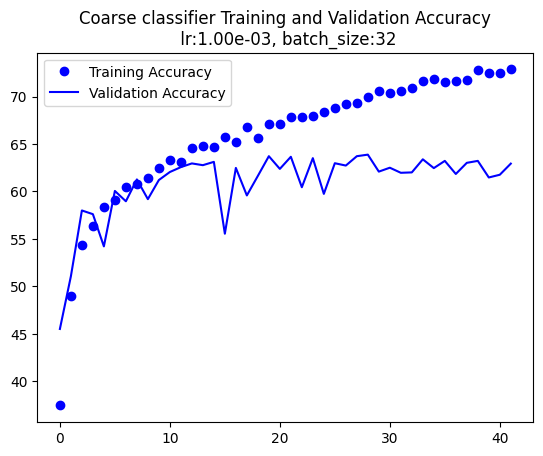

***********---------------************
epoch: 42
training:accuracy:72.68%
test:accuracy:61.31%


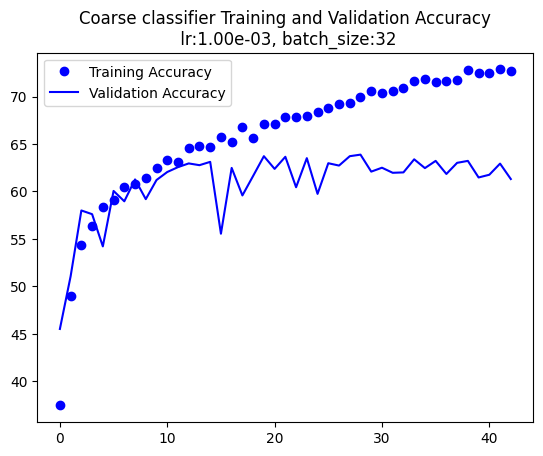

***********---------------************
epoch: 43
training:accuracy:72.93%
test:accuracy:63.10%


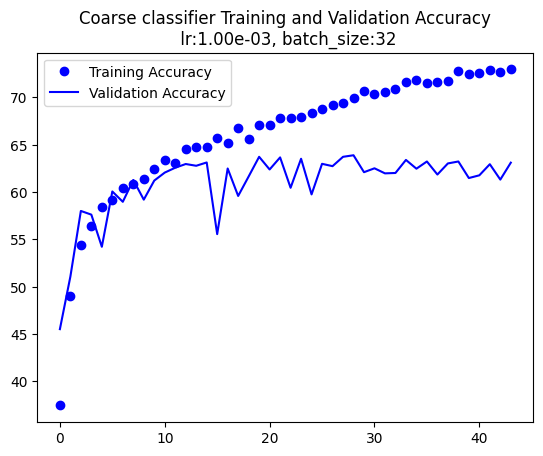

***********---------------************
epoch: 44
training:accuracy:72.83%
test:accuracy:63.34%


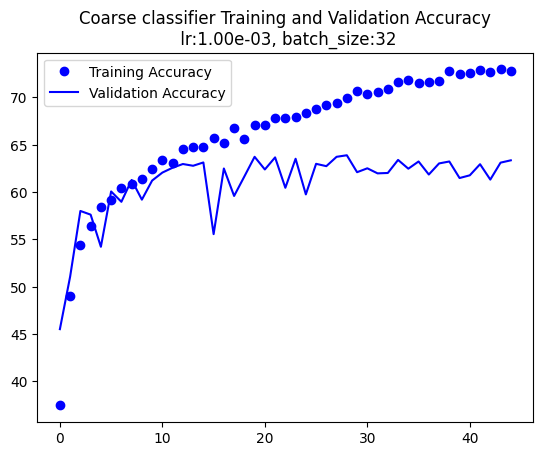

***********---------------************
epoch: 45
training:accuracy:73.78%
test:accuracy:63.53%


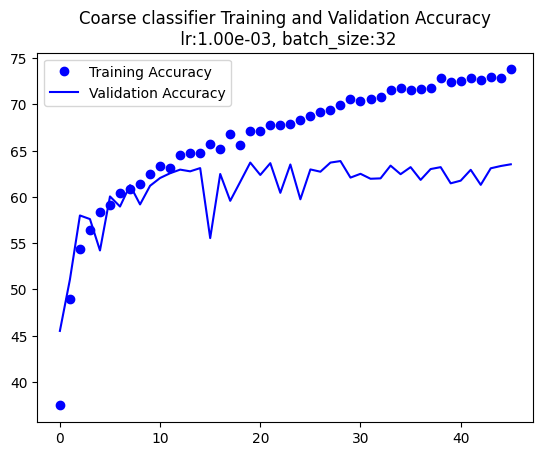

***********---------------************
epoch: 46
training:accuracy:73.70%
test:accuracy:63.01%


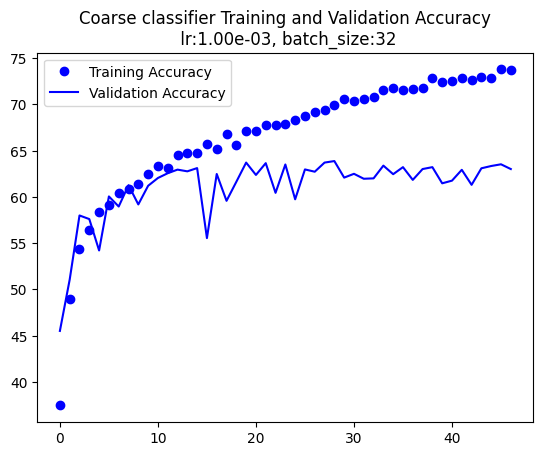

***********---------------************
epoch: 47
training:accuracy:74.42%
test:accuracy:62.38%


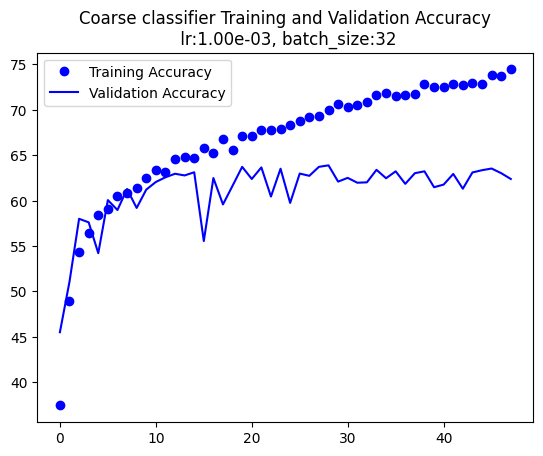

***********---------------************
epoch: 48
training:accuracy:74.26%
test:accuracy:62.79%


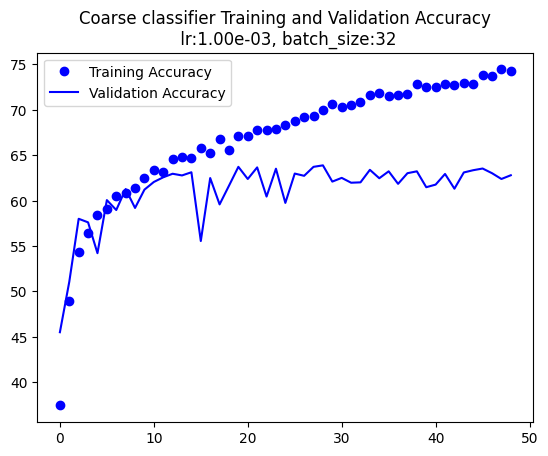

***********---------------************
epoch: 49
training:accuracy:74.10%
test:accuracy:61.78%


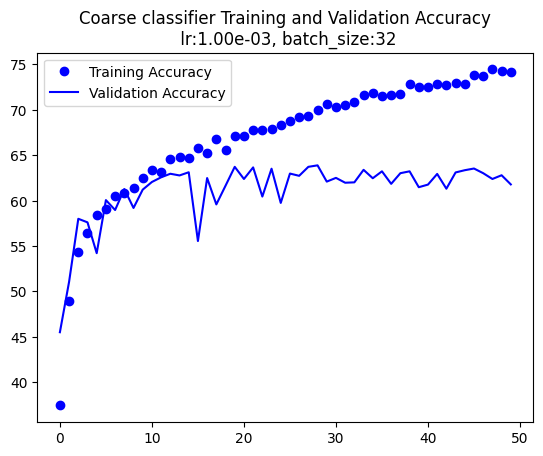

***********---------------************
epoch: 50
training:accuracy:74.95%
test:accuracy:64.02%


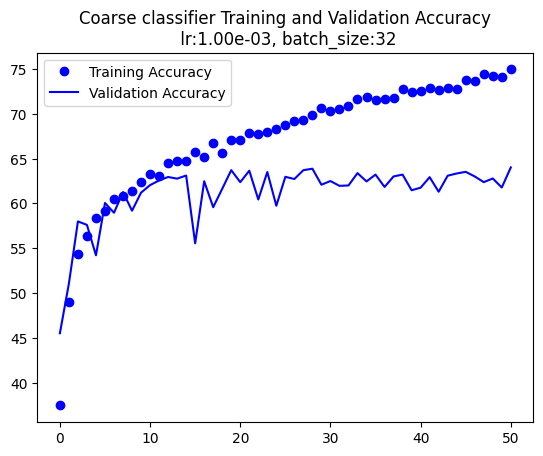

***********---------------************
epoch: 51
training:accuracy:74.73%
test:accuracy:62.48%


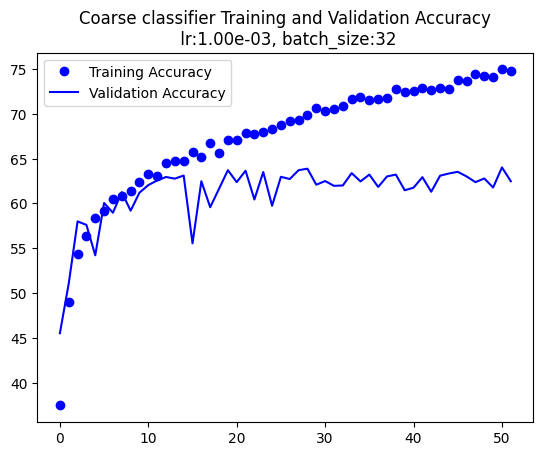

***********---------------************
epoch: 52
training:accuracy:75.08%
test:accuracy:63.38%


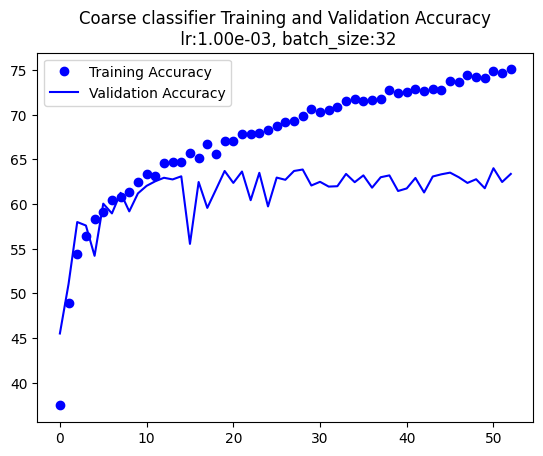

***********---------------************
epoch: 53
training:accuracy:74.88%
test:accuracy:61.35%


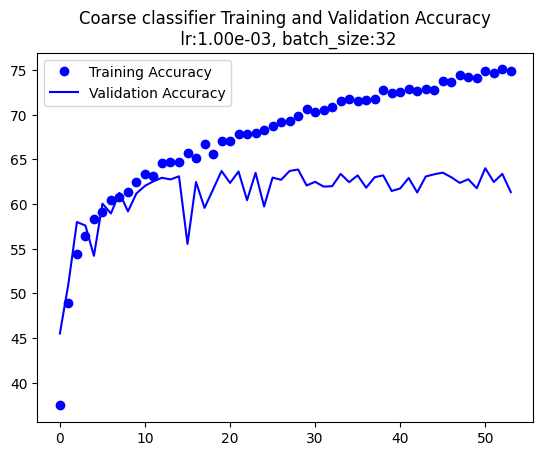

***********---------------************
epoch: 54
training:accuracy:75.13%
test:accuracy:61.66%


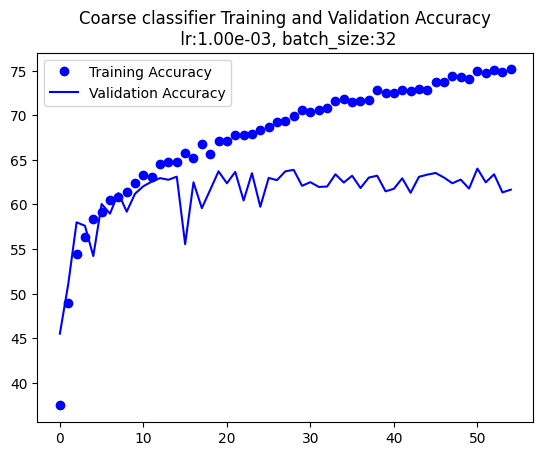

***********---------------************
epoch: 55
training:accuracy:74.67%
test:accuracy:61.04%


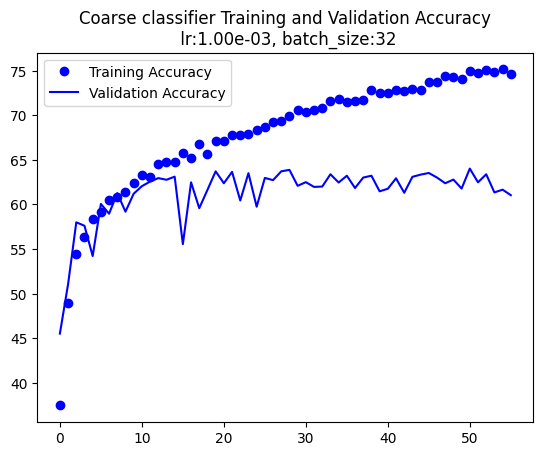

***********---------------************
epoch: 56
training:accuracy:75.71%
test:accuracy:62.81%


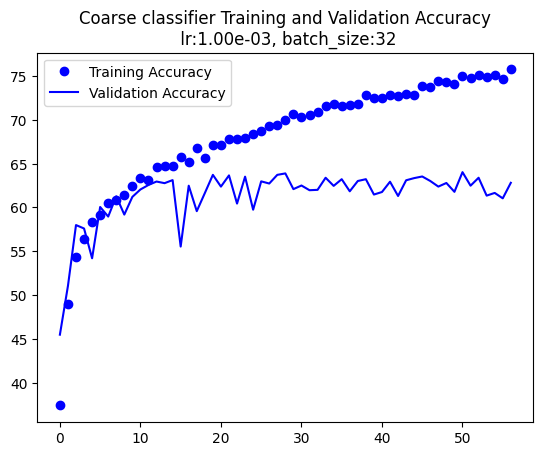

***********---------------************
epoch: 57
training:accuracy:76.16%
test:accuracy:61.02%


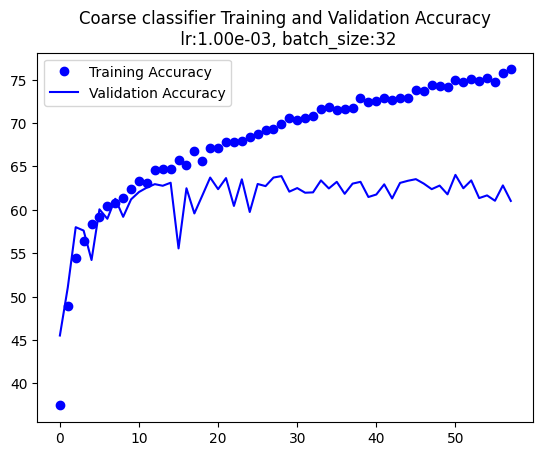

***********---------------************
epoch: 58
training:accuracy:76.19%
test:accuracy:62.58%


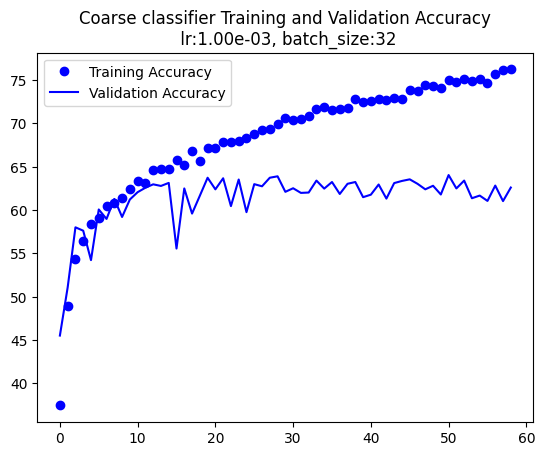

***********---------------************
epoch: 59
training:accuracy:76.00%
test:accuracy:62.73%


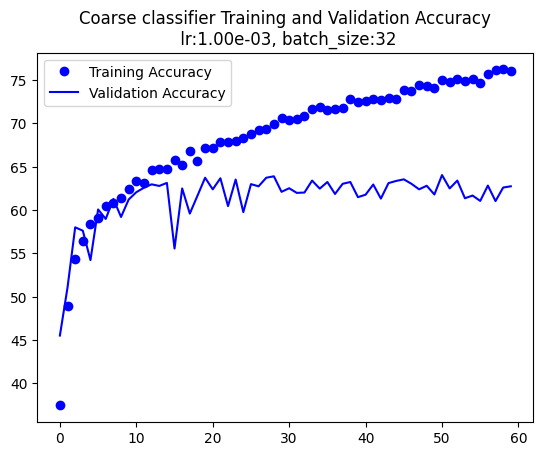

***********---------------************
epoch: 60
training:accuracy:75.82%
test:accuracy:63.06%


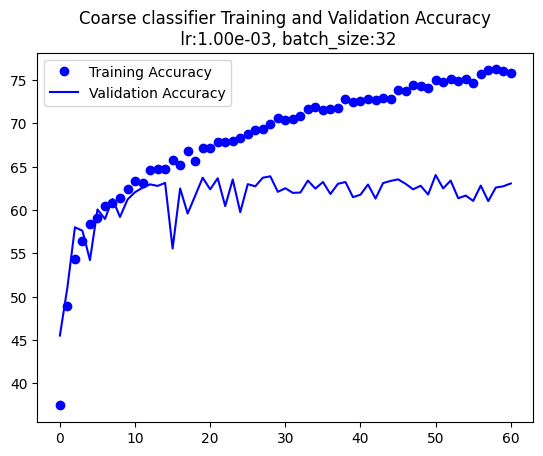

***********---------------************
epoch: 61
training:accuracy:76.12%
test:accuracy:61.55%


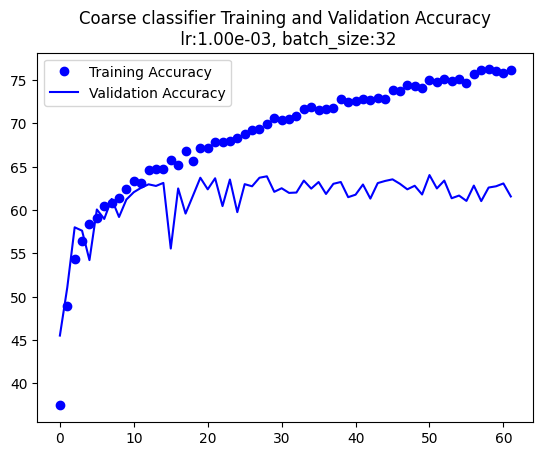

***********---------------************
epoch: 62
training:accuracy:76.49%
test:accuracy:63.08%


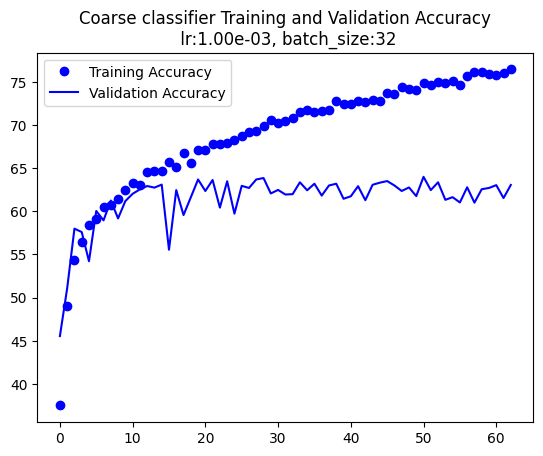

***********---------------************
epoch: 63
training:accuracy:76.94%
test:accuracy:62.44%


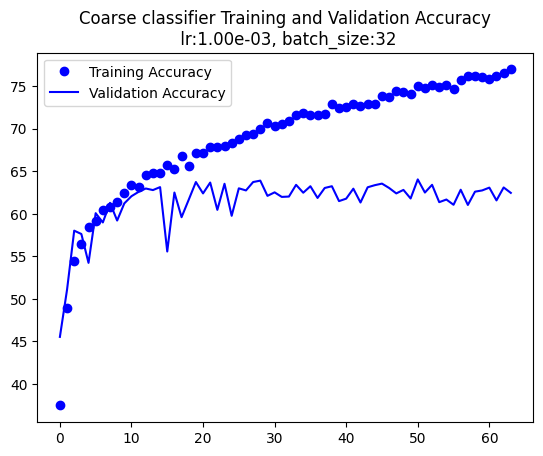

***********---------------************
epoch: 64
training:accuracy:76.78%
test:accuracy:62.71%


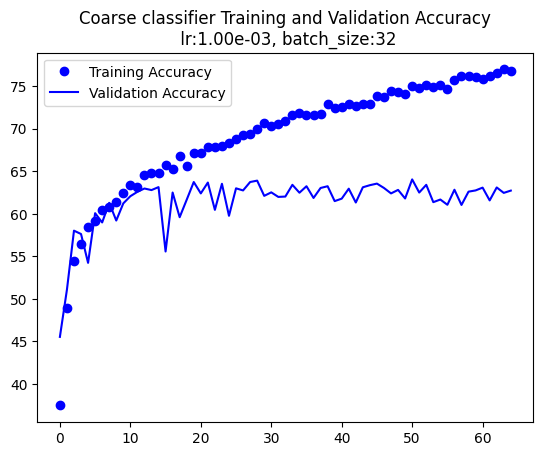

***********---------------************
epoch: 65
training:accuracy:76.79%
test:accuracy:62.13%


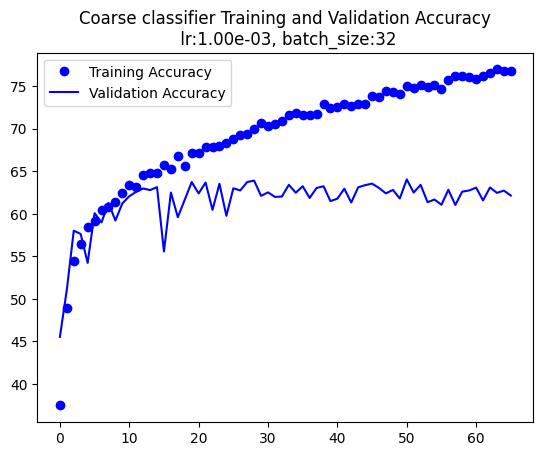

***********---------------************
epoch: 66
training:accuracy:80.06%
test:accuracy:63.12%


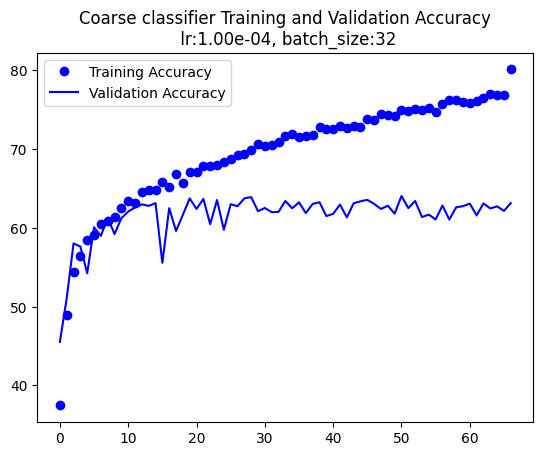

***********---------------************
epoch: 67
training:accuracy:81.24%
test:accuracy:63.38%


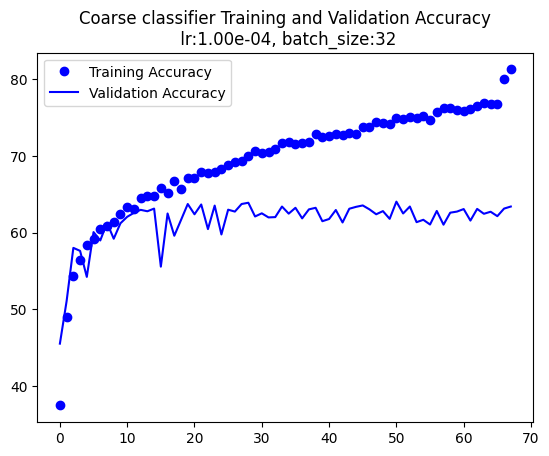

***********---------------************
epoch: 68
training:accuracy:82.15%
test:accuracy:63.88%


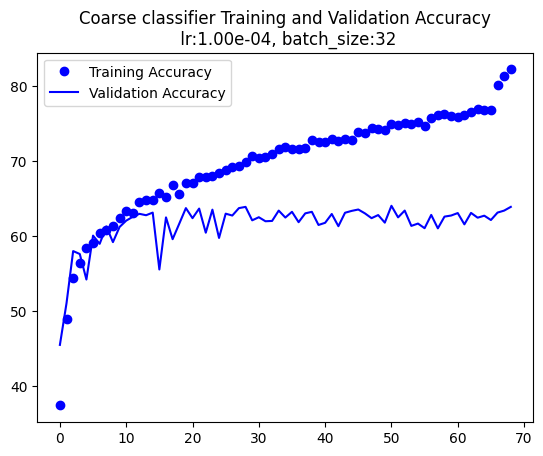

***********---------------************
epoch: 69
training:accuracy:82.09%
test:accuracy:63.59%


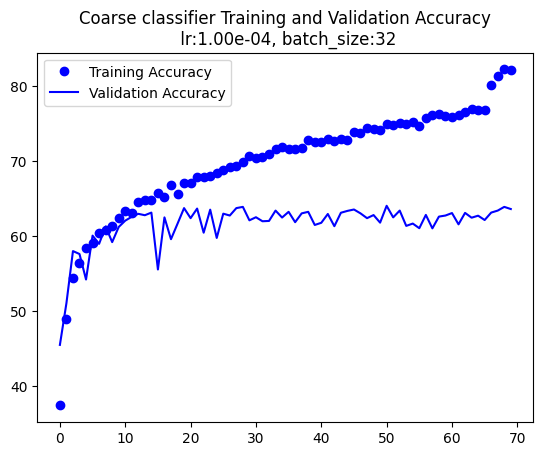

***********---------------************
epoch: 70
training:accuracy:82.48%
test:accuracy:63.69%


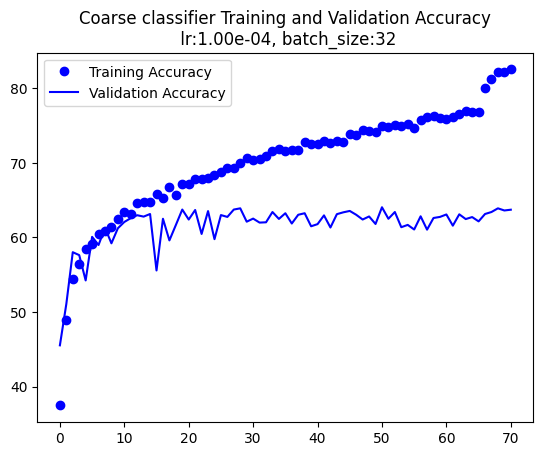

***********---------------************
epoch: 71
training:accuracy:82.44%
test:accuracy:63.28%


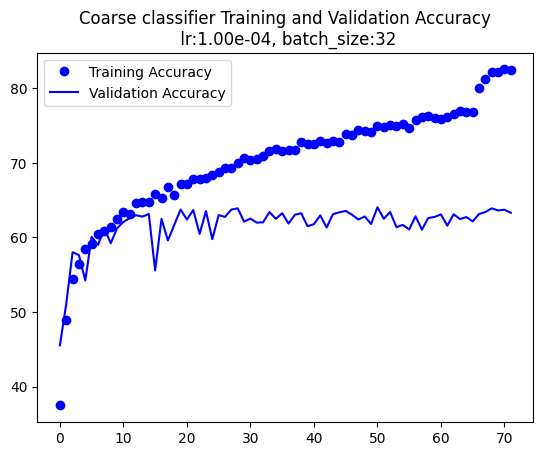

***********---------------************
epoch: 72
training:accuracy:82.82%
test:accuracy:63.65%


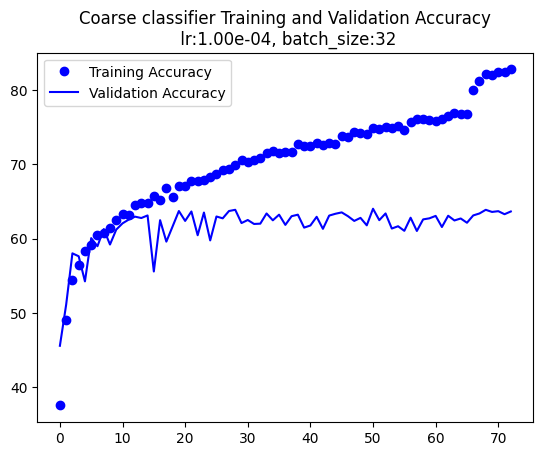

***********---------------************
epoch: 73
training:accuracy:83.14%
test:accuracy:63.32%


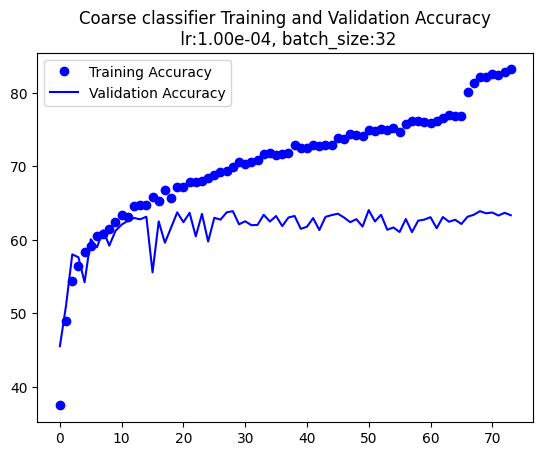

***********---------------************
epoch: 74
training:accuracy:83.65%
test:accuracy:63.65%


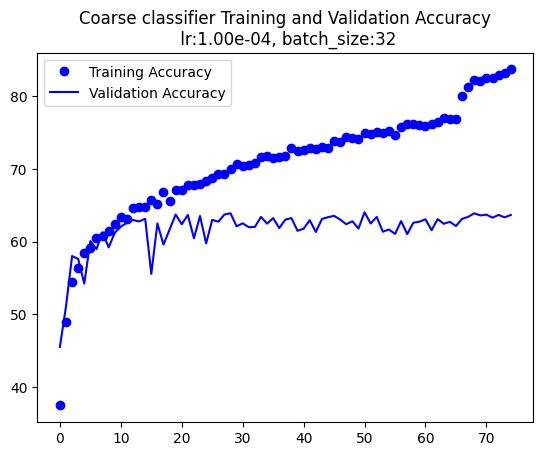

***********---------------************
epoch: 75
training:accuracy:83.62%
test:accuracy:62.95%


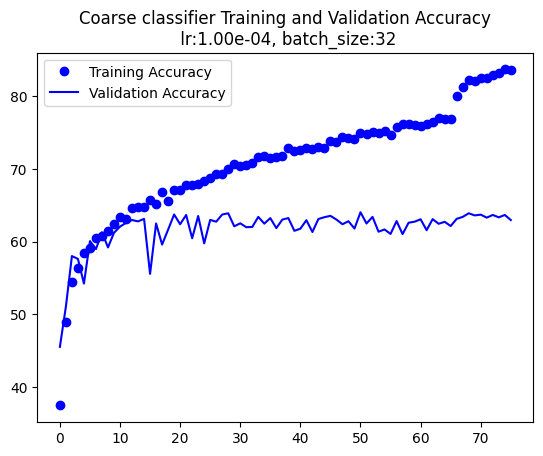

***********---------------************
epoch: 76
training:accuracy:83.69%
test:accuracy:63.12%


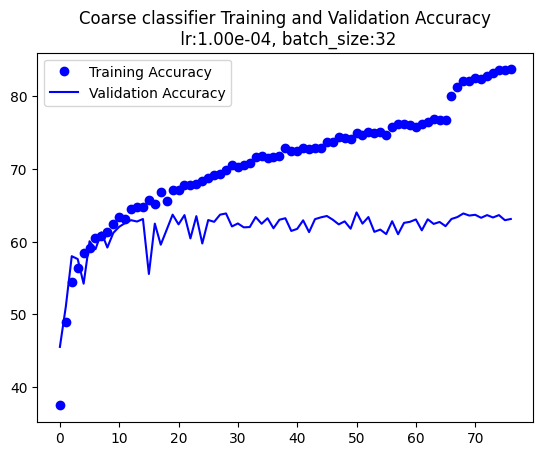

***********---------------************
epoch: 77
training:accuracy:84.02%
test:accuracy:62.97%


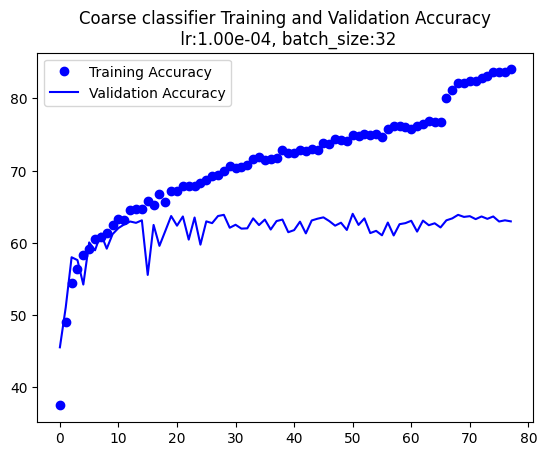

***********---------------************
epoch: 78
training:accuracy:83.92%
test:accuracy:62.71%


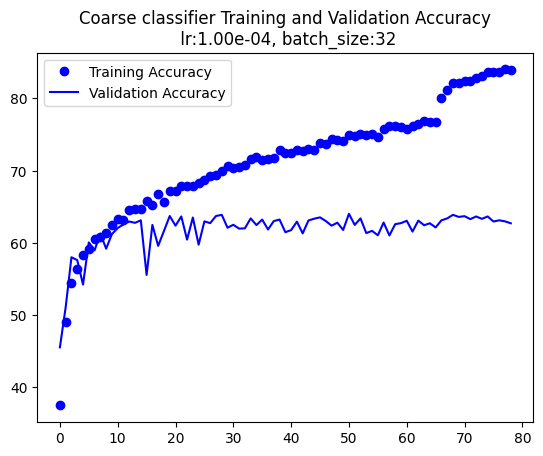

***********---------------************
epoch: 79
training:accuracy:84.53%
test:accuracy:62.85%


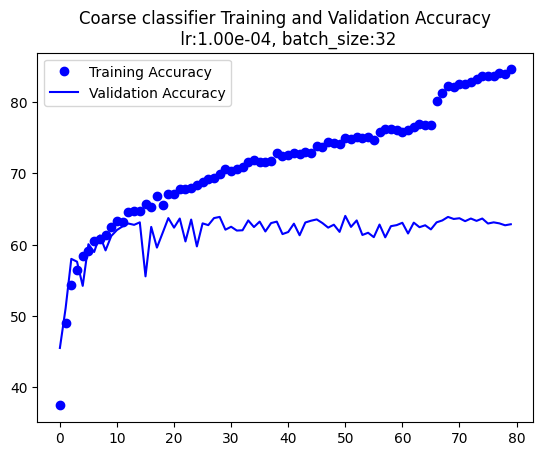

***********---------------************
epoch: 80
training:accuracy:84.63%
test:accuracy:63.28%


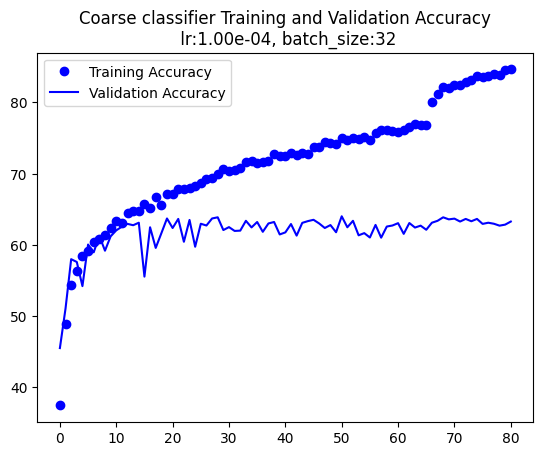

***********---------------************
epoch: 81
training:accuracy:84.17%
test:accuracy:63.49%


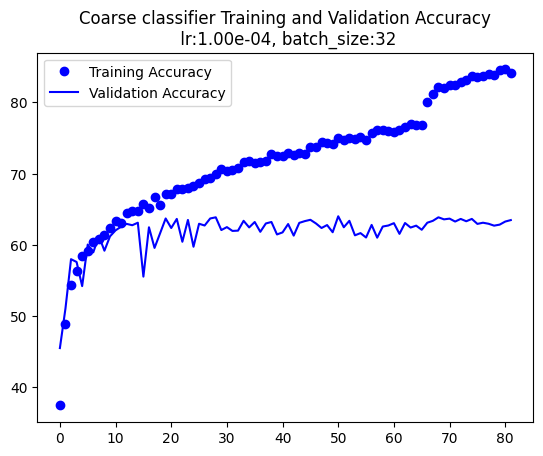

***********---------------************
epoch: 82
training:accuracy:84.68%
test:accuracy:62.71%


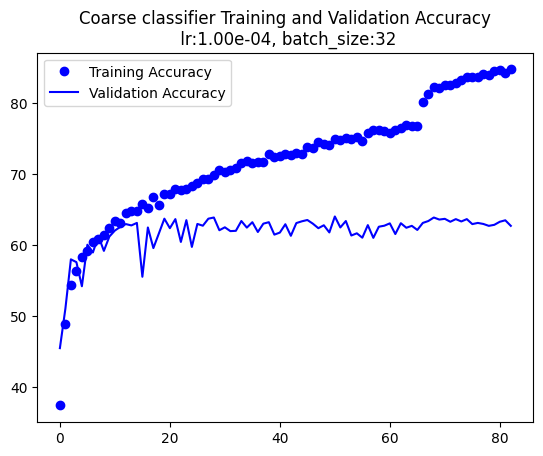

***********---------------************
epoch: 83
training:accuracy:84.80%
test:accuracy:63.10%


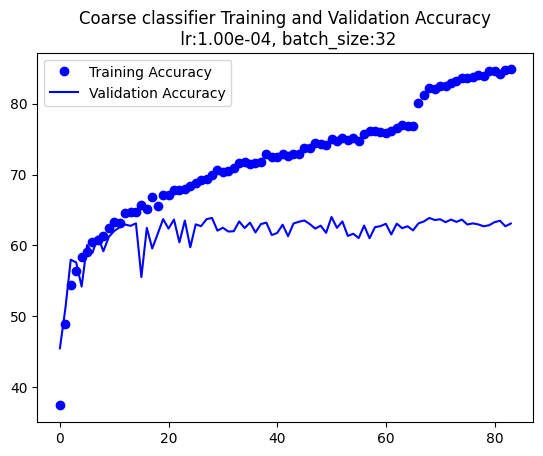

***********---------------************
epoch: 84
training:accuracy:84.87%
test:accuracy:63.40%


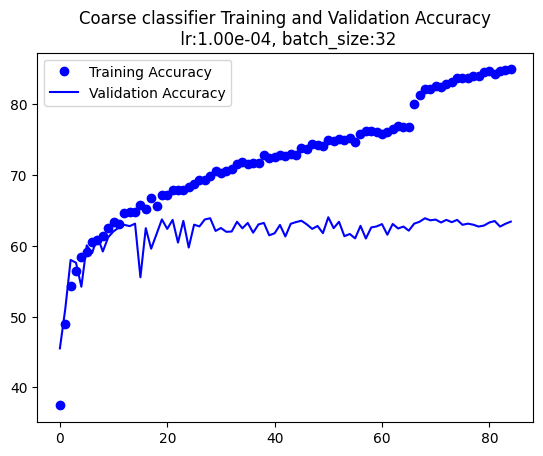

***********---------------************
epoch: 85
training:accuracy:84.78%
test:accuracy:63.28%


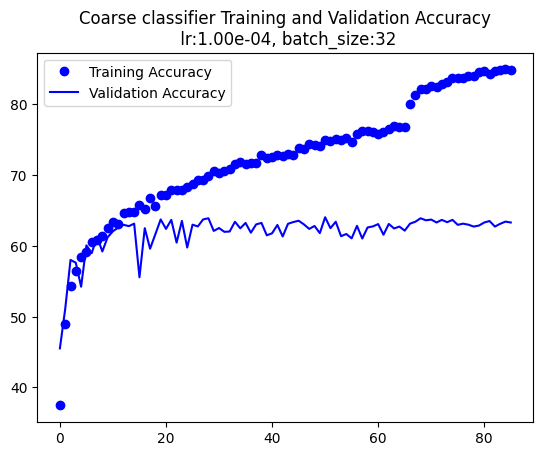

***********---------------************
epoch: 86
training:accuracy:85.31%
test:accuracy:62.48%


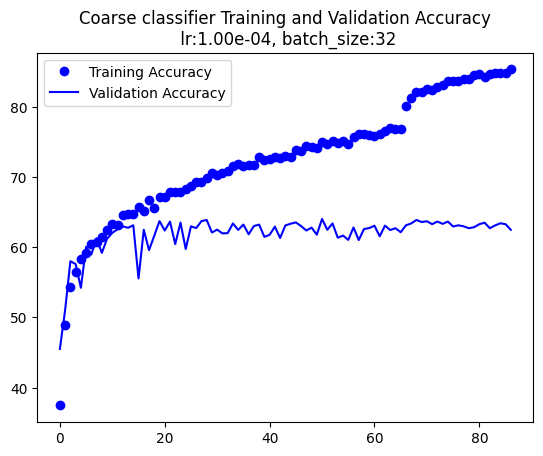

***********---------------************
epoch: 87
training:accuracy:85.65%
test:accuracy:62.77%


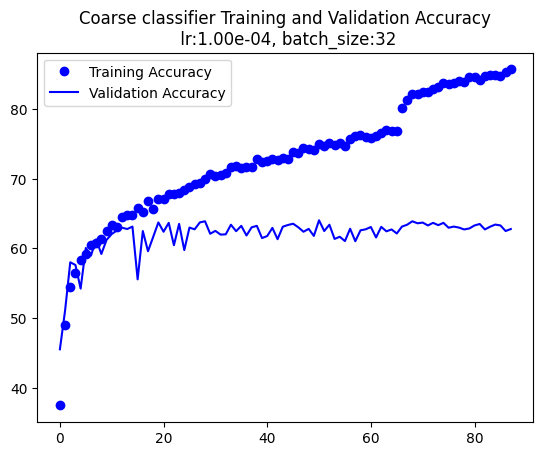

***********---------------************
epoch: 88
training:accuracy:85.30%
test:accuracy:62.79%


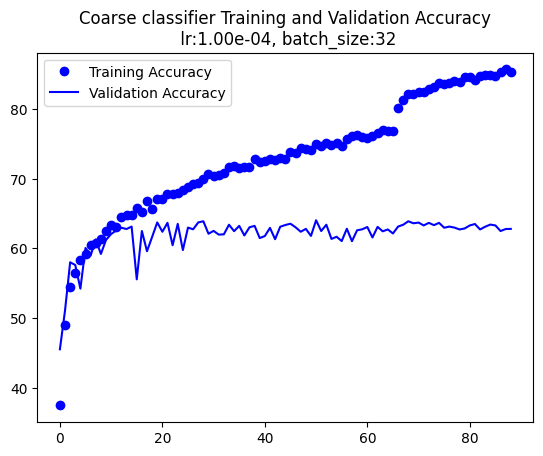

***********---------------************
epoch: 89
training:accuracy:85.42%
test:accuracy:62.23%


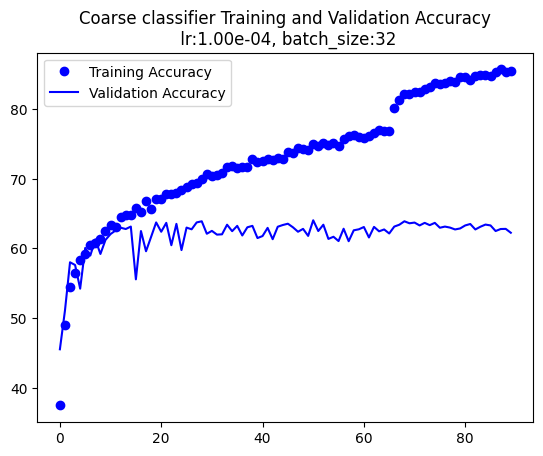

***********---------------************
epoch: 90
training:accuracy:85.62%
test:accuracy:62.42%


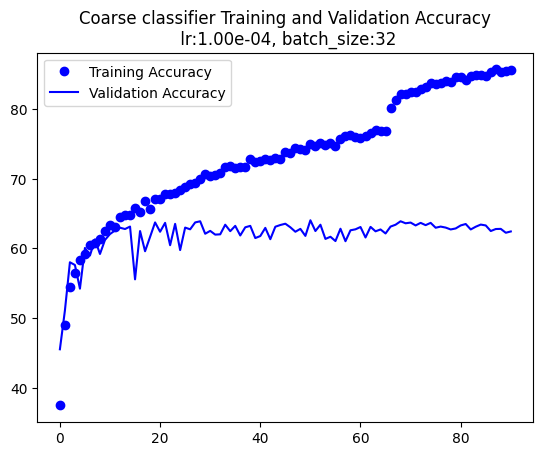

***********---------------************
epoch: 91
training:accuracy:85.84%
test:accuracy:62.52%


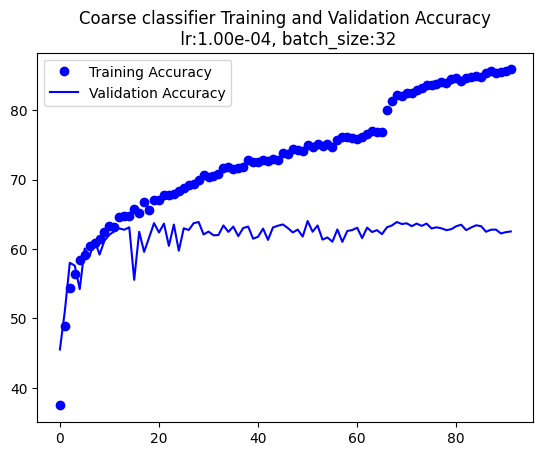

***********---------------************
epoch: 92
training:accuracy:86.04%
test:accuracy:63.14%


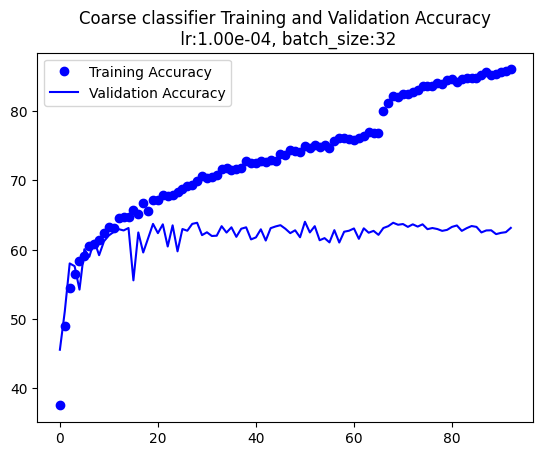

***********---------------************
epoch: 93
training:accuracy:86.00%
test:accuracy:63.51%


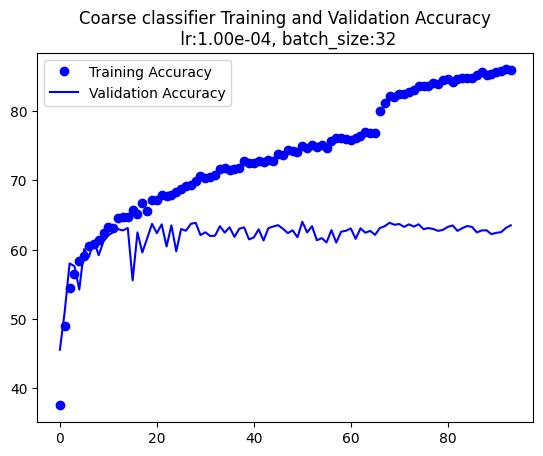

***********---------------************
epoch: 94
training:accuracy:85.86%
test:accuracy:62.99%


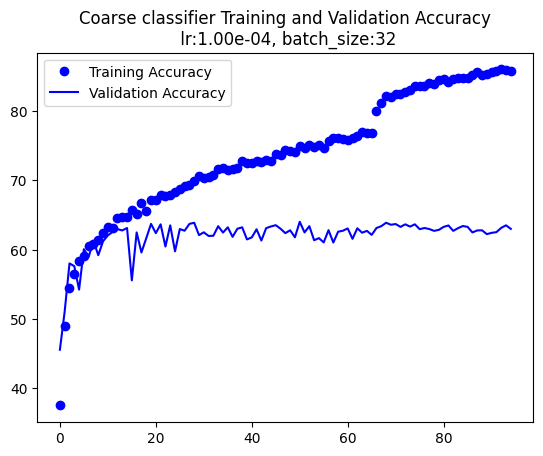

***********---------------************
epoch: 95
training:accuracy:86.14%
test:accuracy:62.46%


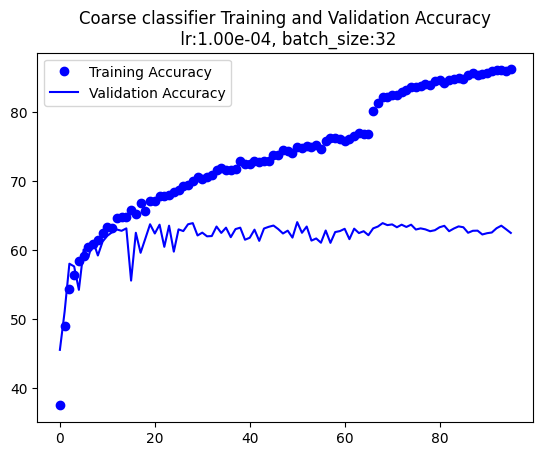

***********---------------************
epoch: 96
training:accuracy:85.91%
test:accuracy:62.52%


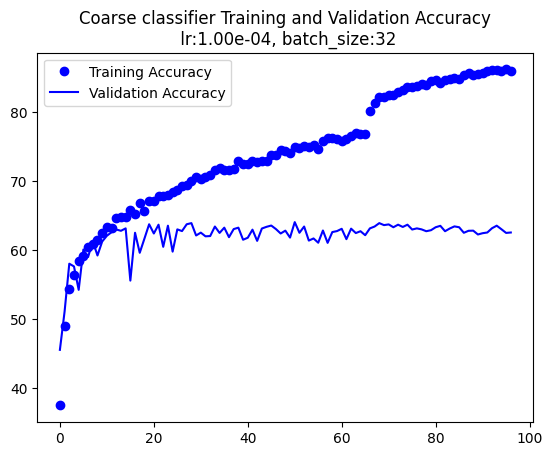

***********---------------************
epoch: 97
training:accuracy:86.27%
test:accuracy:62.89%


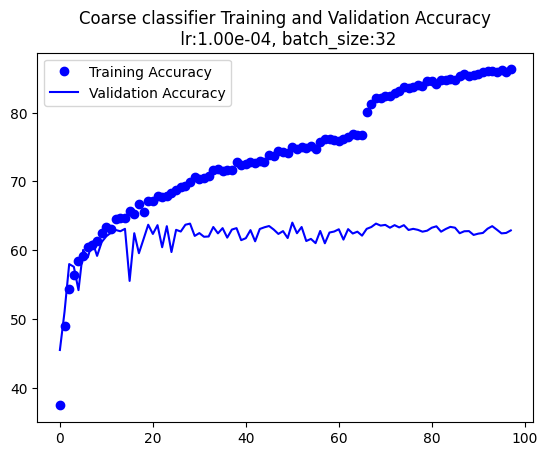

***********---------------************
epoch: 98
training:accuracy:86.22%
test:accuracy:62.71%


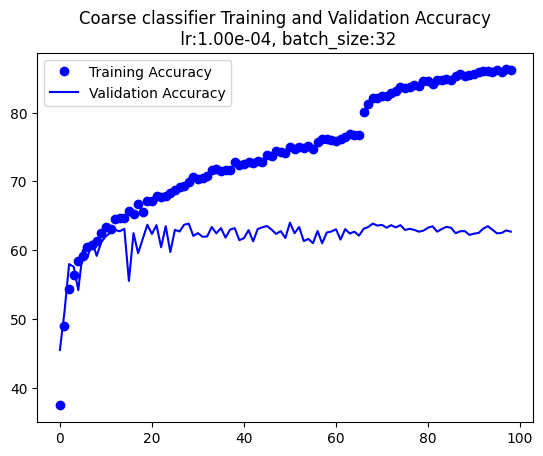

***********---------------************
epoch: 99
training:accuracy:86.56%
test:accuracy:62.77%


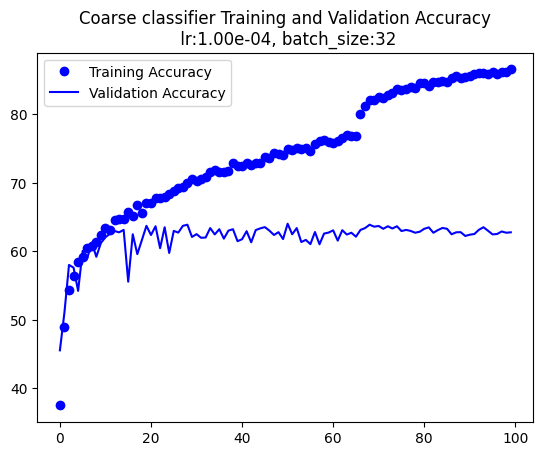

***********---------------************


In [ ]:

device = torch.device('cuda')
# lr=8.5e-4
# lr=6.5e-4
lr=0.001
epochs=100
n_coarse_classes=4
# x_train,y_train,x_valid,y_valid=x_train.to(device),y_train.to(device),x_valid.to(device),y_valid.to(device)
# model=My_CNN(1,32,7)
# model = ResNet(img_channels=1, num_layers=18, block=BasicBlock, num_classes=7,in_channels=32)
# model = HierarchicalCNN(3,fine_classes)
coarse_model=CoarseClassifier(n_coarse_classes).to(device)
# if torch.cuda.is_available():
coarse_model.to(device)

    # model = nn.DataParallel(model)
optimizer = optim.Adam(coarse_model.parameters(), lr=lr,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
train_step_coarse(model=coarse_model,num_epochs=epochs,dataloader_train=dataloader_train,dataloader_valid=dataloader_valid)

In [ ]:
df[['emotion']].value_counts()

emotion
6          623
5          113
3          100
1           88
0           75
4           59
2           57
dtype: int64

In [ ]:
from google.colab import files

num_parameters = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters in fine model: {num_parameters}")
torch.save(coarse_model, 'coarse model.pth')
# coarse_model = torch.load('coarse model.pth')
files.download('/content/coarse model.pth')

Total number of parameters in fine model: 570180


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

epoch: 0
training:accuracy:76.31%
test:accuracy:79.26%


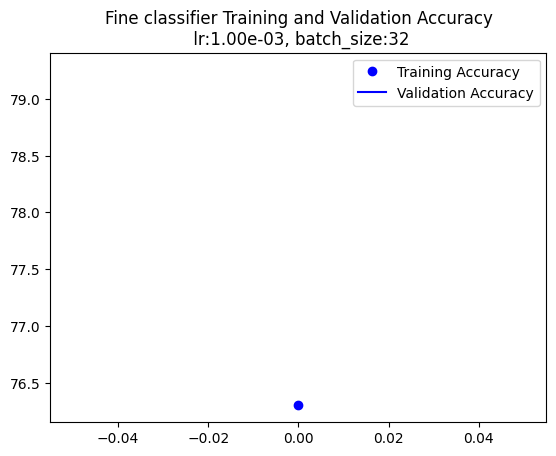


epoch: 1
training:accuracy:81.15%
test:accuracy:83.20%


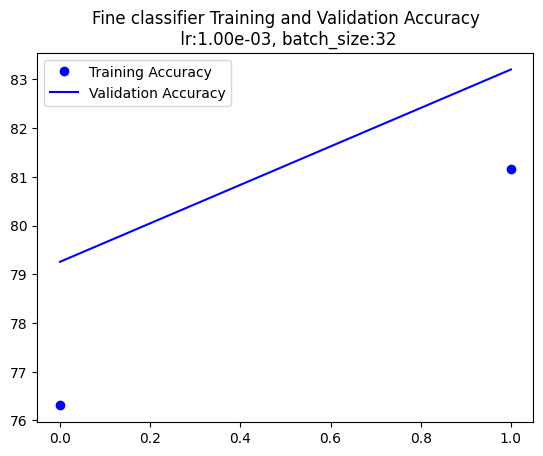


epoch: 2
training:accuracy:82.70%
test:accuracy:83.02%


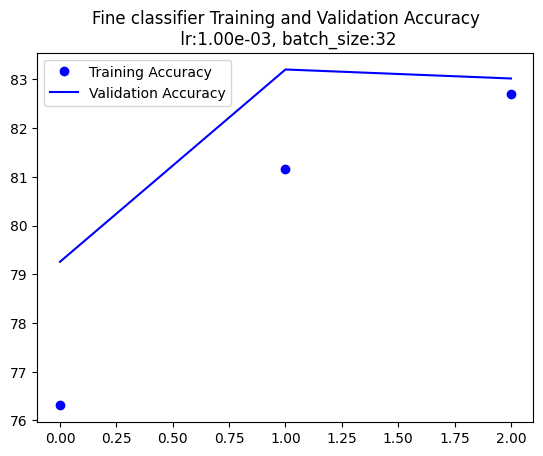


epoch: 3
training:accuracy:82.83%
test:accuracy:84.15%


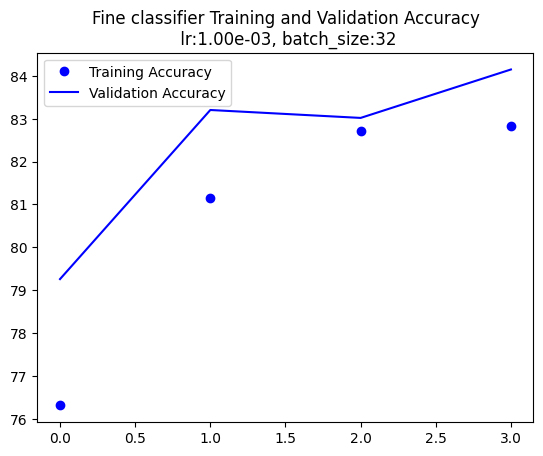


epoch: 4
training:accuracy:83.16%
test:accuracy:84.09%


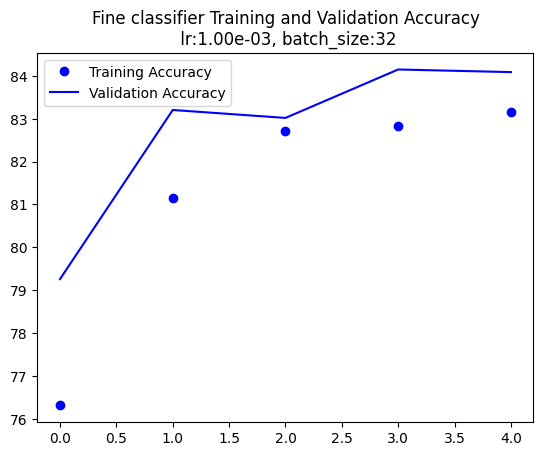


epoch: 5
training:accuracy:84.04%
test:accuracy:82.36%


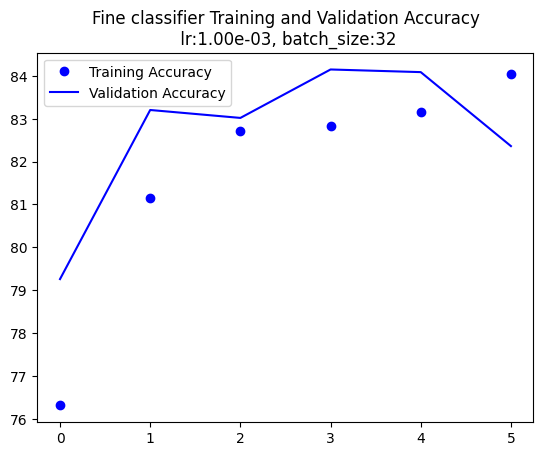


epoch: 6
training:accuracy:84.03%
test:accuracy:84.00%


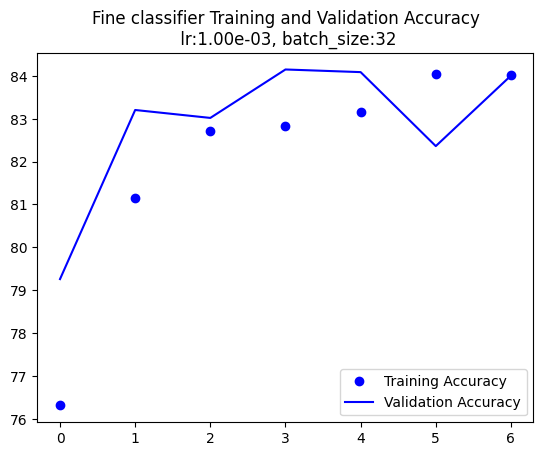


epoch: 7
training:accuracy:84.75%
test:accuracy:81.81%


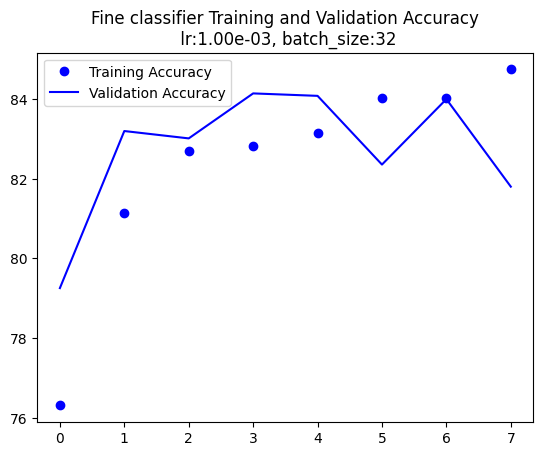


epoch: 8
training:accuracy:85.41%
test:accuracy:84.35%


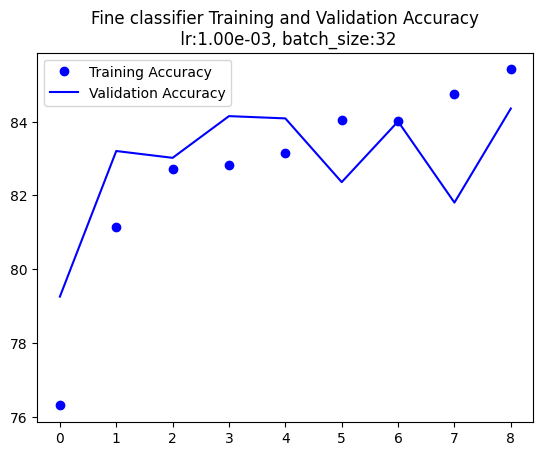


epoch: 9
training:accuracy:85.43%
test:accuracy:83.78%


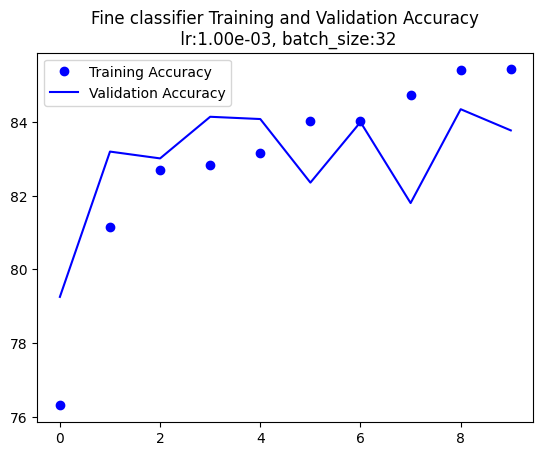


epoch: 10
training:accuracy:85.96%
test:accuracy:83.53%


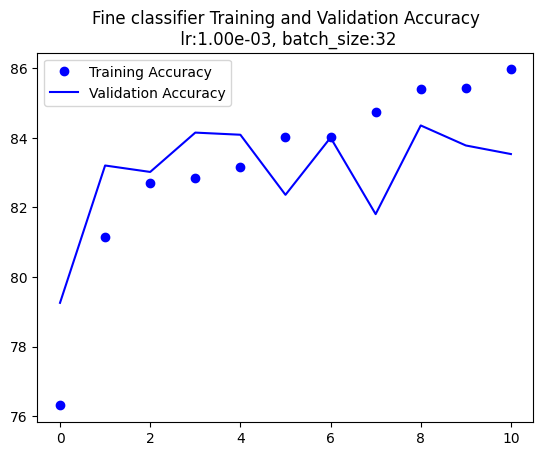


epoch: 11
training:accuracy:85.60%
test:accuracy:82.42%


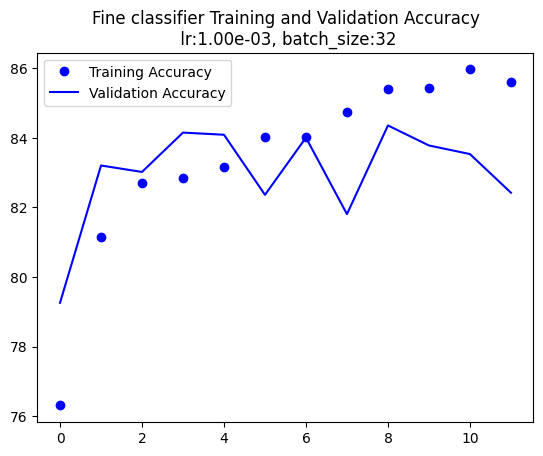


epoch: 12
training:accuracy:85.77%
test:accuracy:83.76%


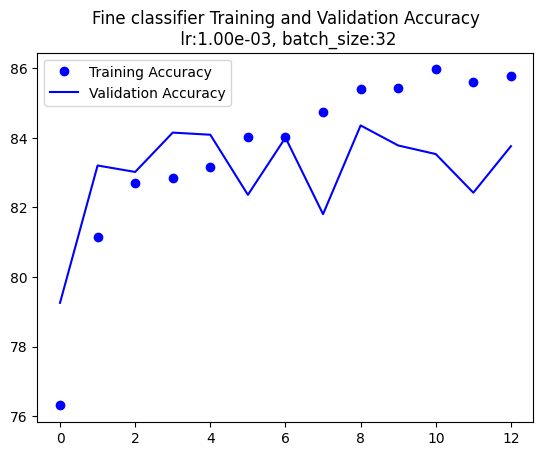


epoch: 13
training:accuracy:86.00%
test:accuracy:83.98%


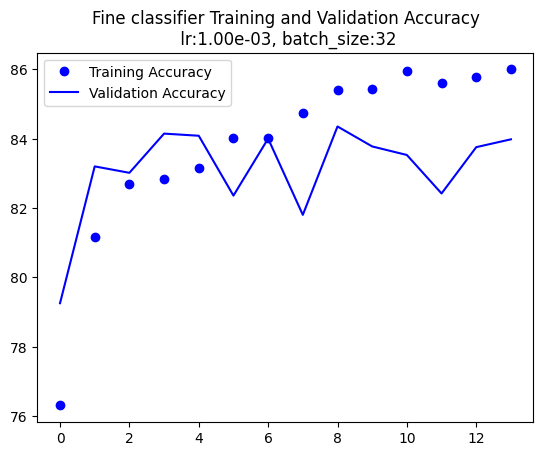


epoch: 14
training:accuracy:86.34%
test:accuracy:83.66%


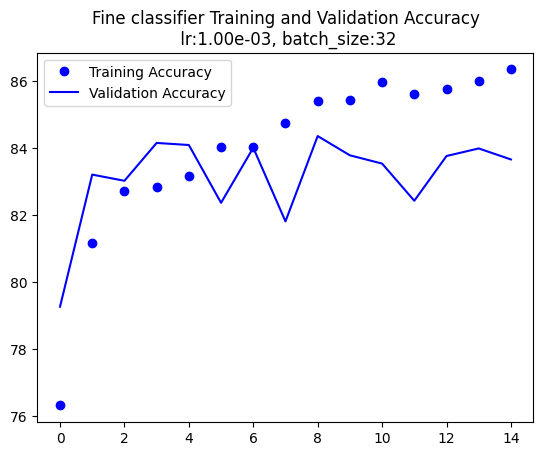


epoch: 15
training:accuracy:86.25%
test:accuracy:84.50%


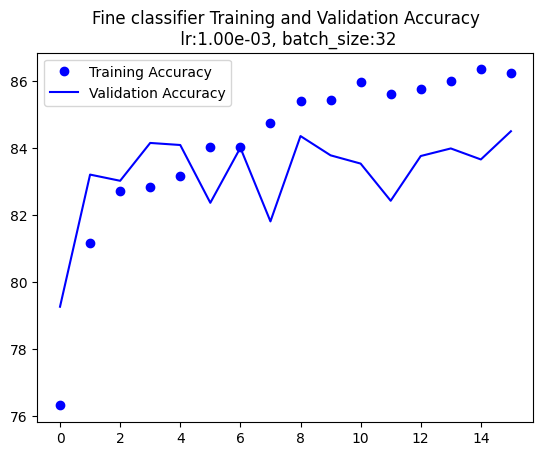


epoch: 16
training:accuracy:87.17%
test:accuracy:84.52%


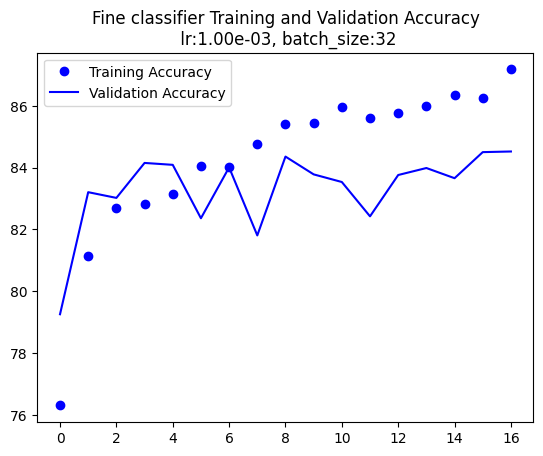


epoch: 17
training:accuracy:86.44%
test:accuracy:84.00%


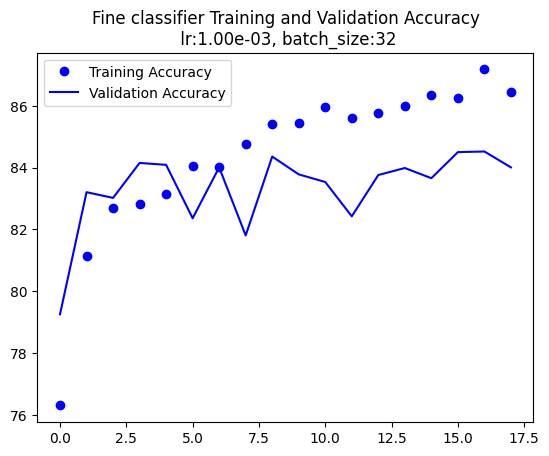


epoch: 18
training:accuracy:86.68%
test:accuracy:84.09%


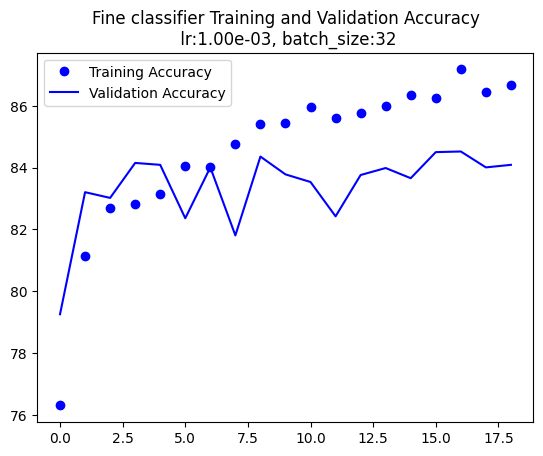


epoch: 19
training:accuracy:87.00%
test:accuracy:82.94%


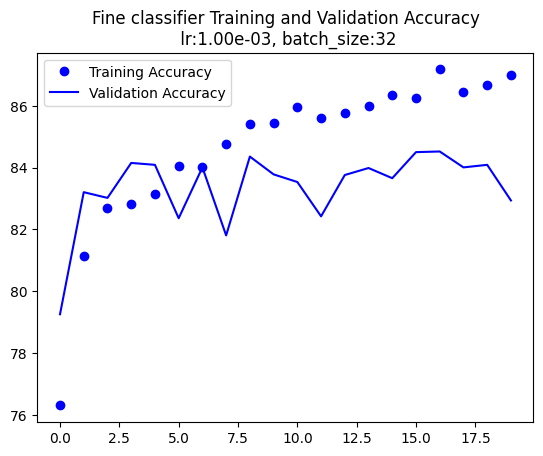


epoch: 20
training:accuracy:87.12%
test:accuracy:84.89%


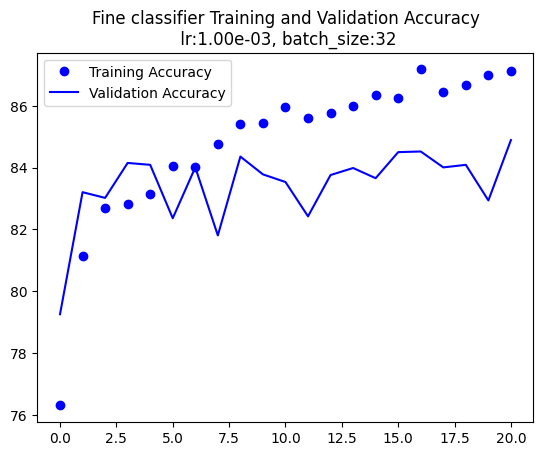


epoch: 21
training:accuracy:87.34%
test:accuracy:83.66%


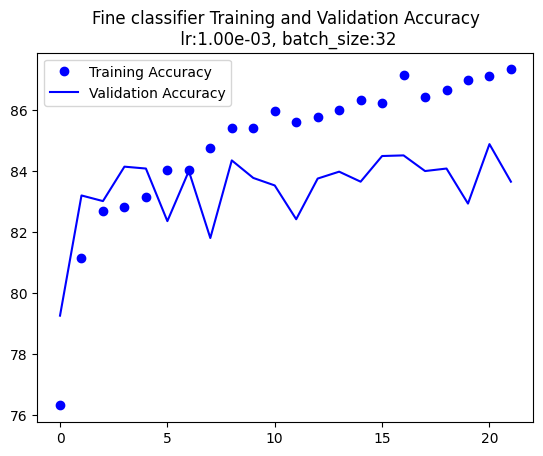


epoch: 22
training:accuracy:87.48%
test:accuracy:83.24%


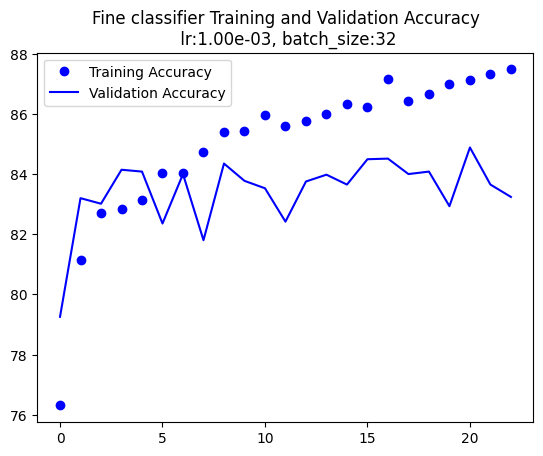


epoch: 23
training:accuracy:87.01%
test:accuracy:84.05%


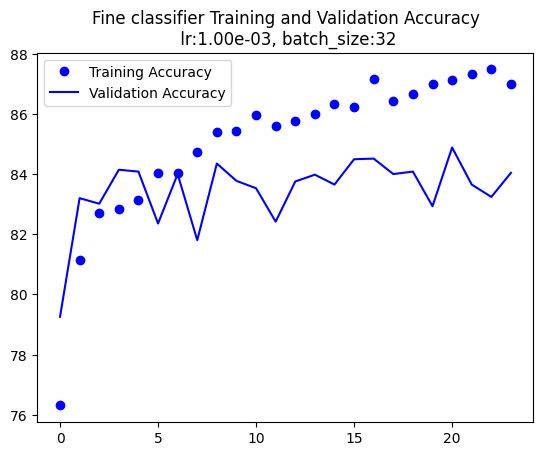


epoch: 24
training:accuracy:86.81%
test:accuracy:84.05%


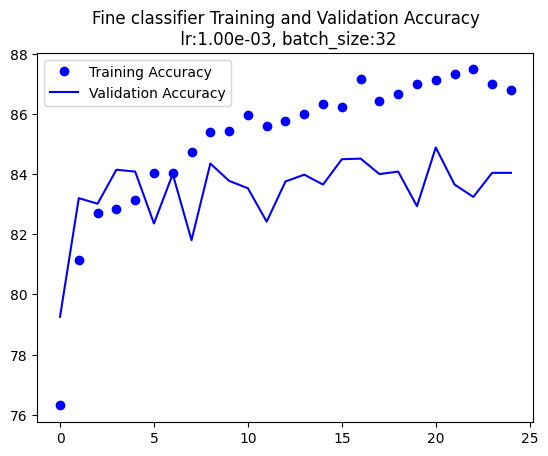


epoch: 25
training:accuracy:87.05%
test:accuracy:83.66%


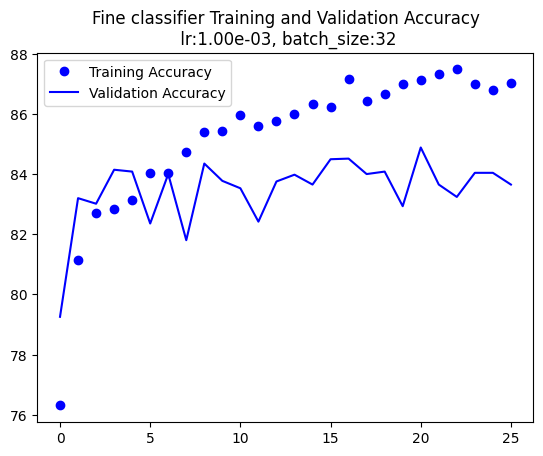


epoch: 26
training:accuracy:87.53%
test:accuracy:84.40%


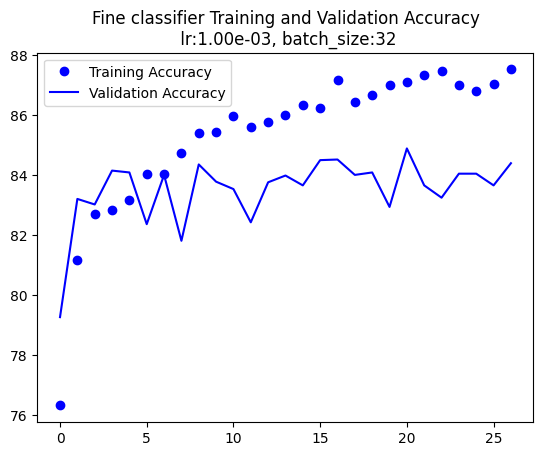


epoch: 27
training:accuracy:87.30%
test:accuracy:84.64%


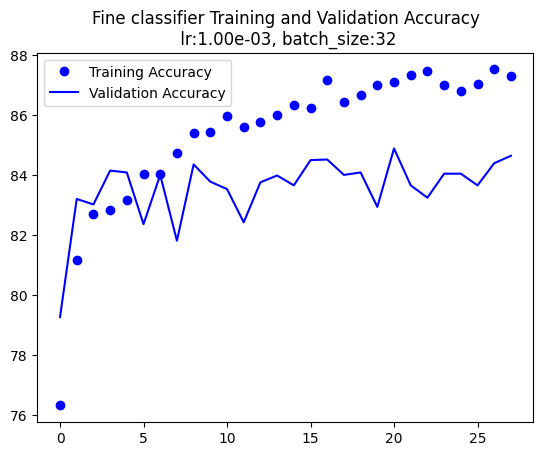


epoch: 28
training:accuracy:87.32%
test:accuracy:84.68%


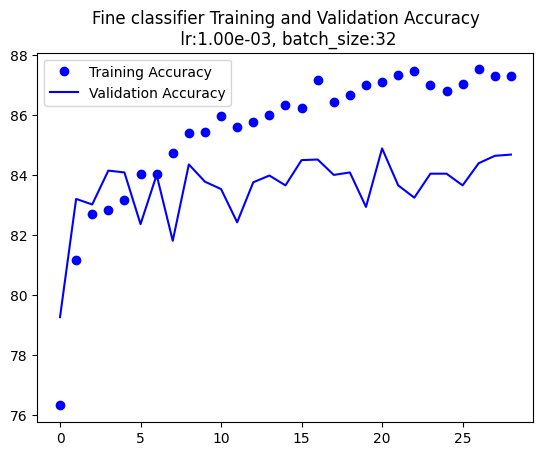


epoch: 29
training:accuracy:88.03%
test:accuracy:82.77%


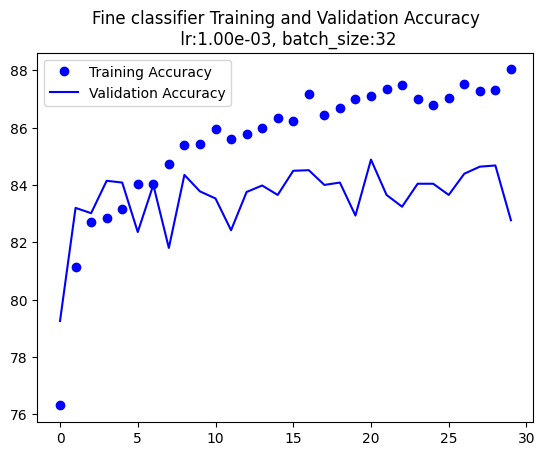


epoch: 30
training:accuracy:87.72%
test:accuracy:84.75%


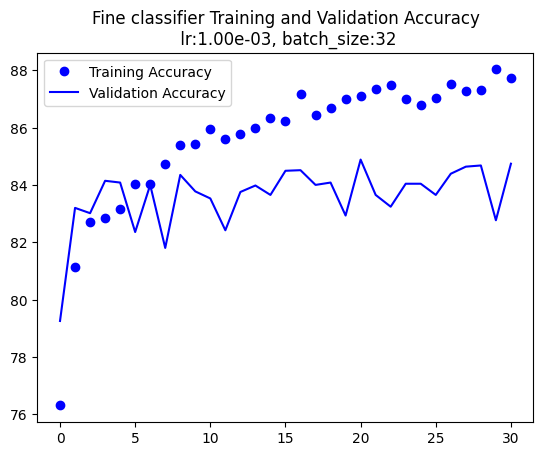


epoch: 31
training:accuracy:88.26%
test:accuracy:84.95%


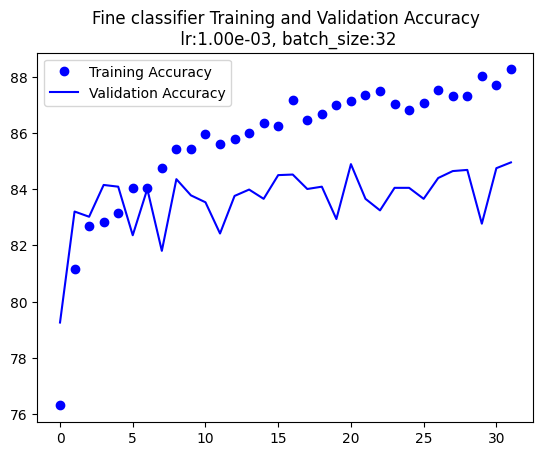


epoch: 32
training:accuracy:87.65%
test:accuracy:82.89%


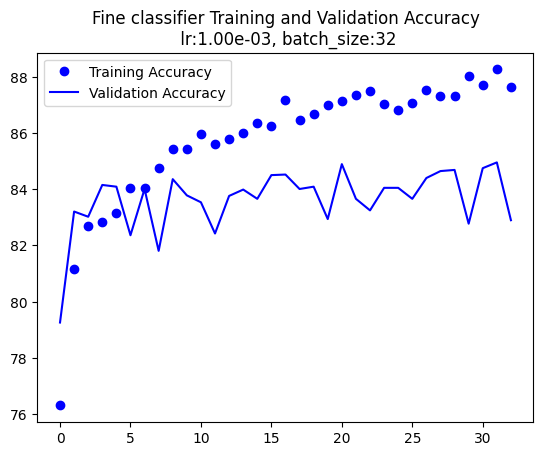


epoch: 33
training:accuracy:88.98%
test:accuracy:84.27%


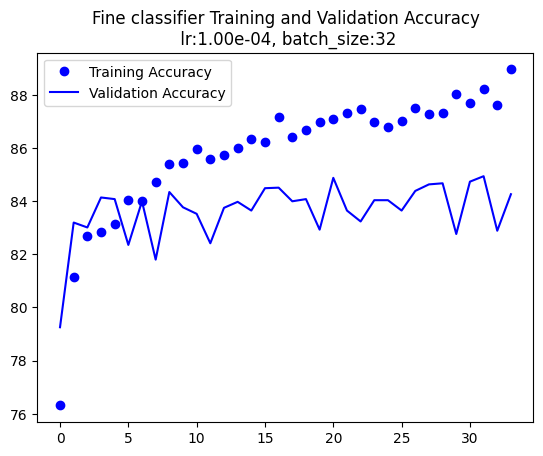


epoch: 34
training:accuracy:88.91%
test:accuracy:84.03%


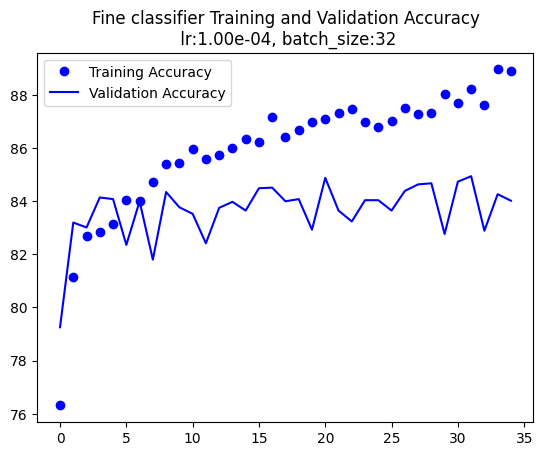


epoch: 35
training:accuracy:89.08%
test:accuracy:84.38%


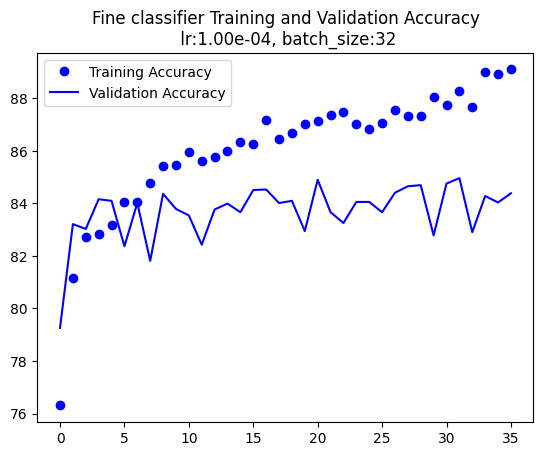


epoch: 36
training:accuracy:89.26%
test:accuracy:84.79%


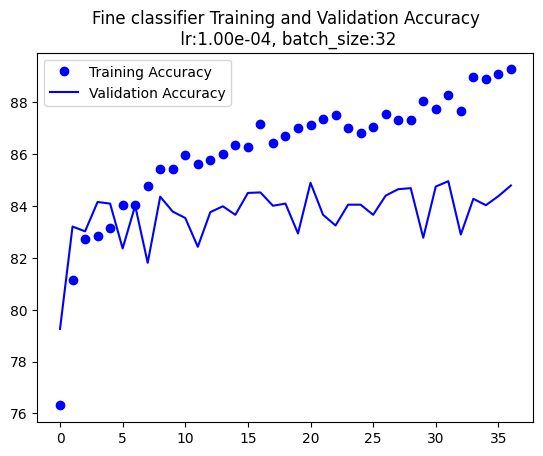


epoch: 37
training:accuracy:89.77%
test:accuracy:84.40%


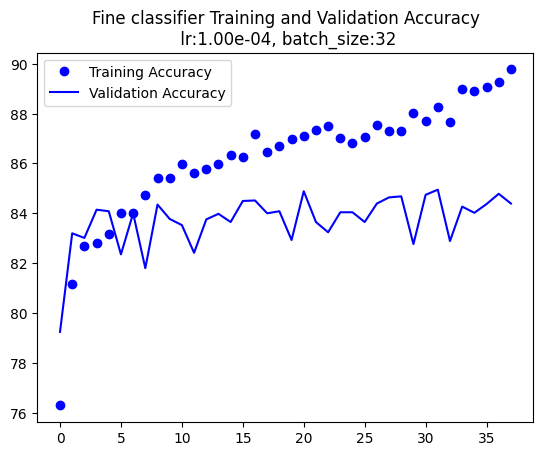


epoch: 38
training:accuracy:89.74%
test:accuracy:84.25%


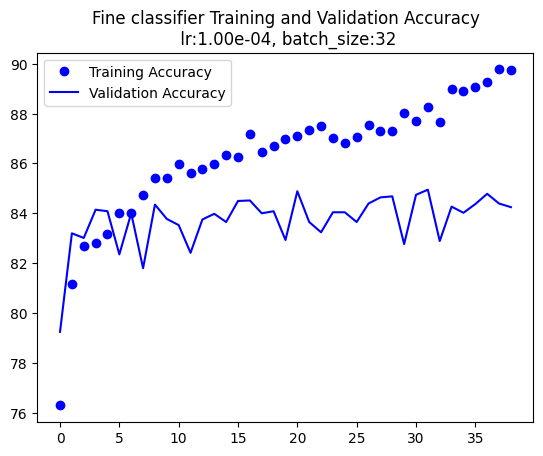


epoch: 39
training:accuracy:89.80%
test:accuracy:84.77%


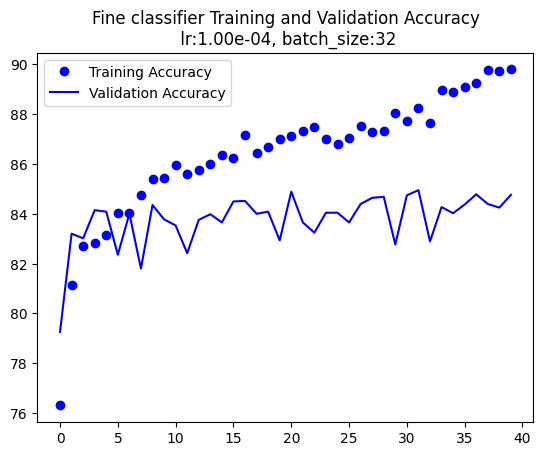


epoch: 40
training:accuracy:89.51%
test:accuracy:84.56%


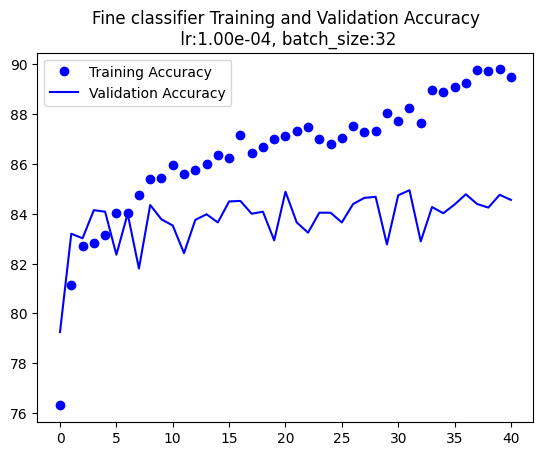


epoch: 41
training:accuracy:89.41%
test:accuracy:84.83%


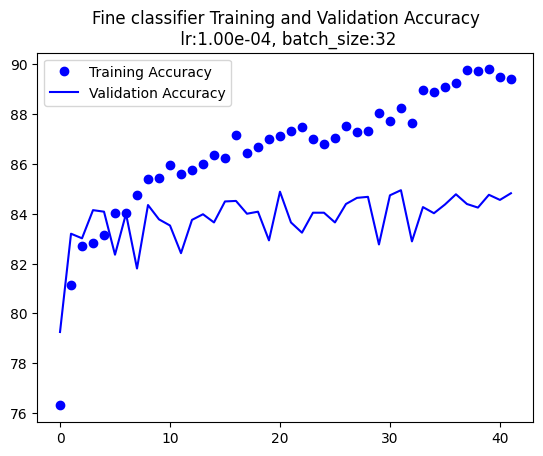


epoch: 42
training:accuracy:89.53%
test:accuracy:84.87%


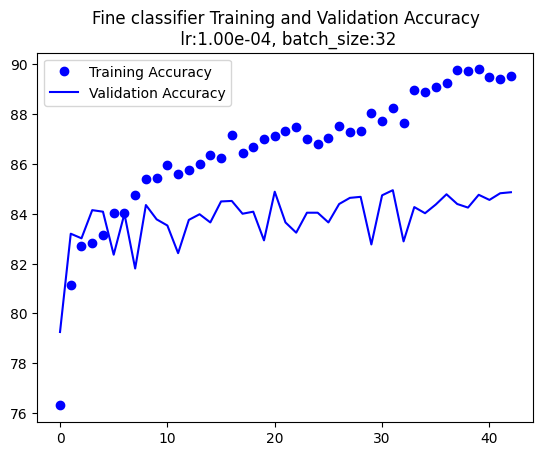


epoch: 43
training:accuracy:89.80%
test:accuracy:84.05%


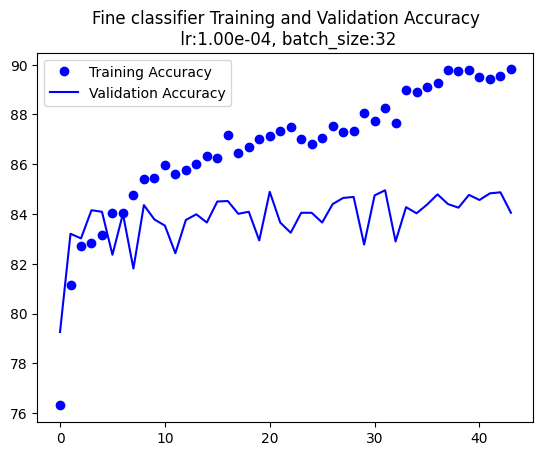


epoch: 44
training:accuracy:89.84%
test:accuracy:84.66%


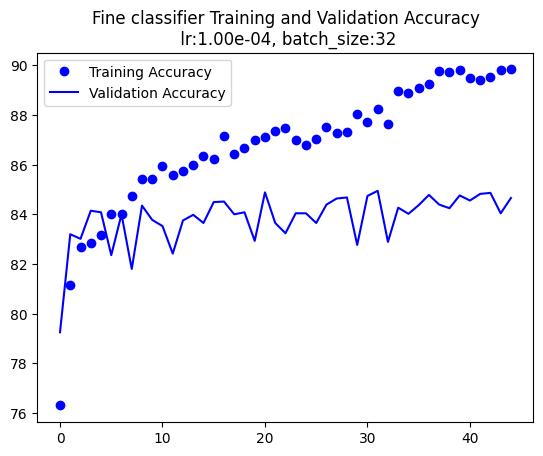


epoch: 45
training:accuracy:89.55%
test:accuracy:84.70%


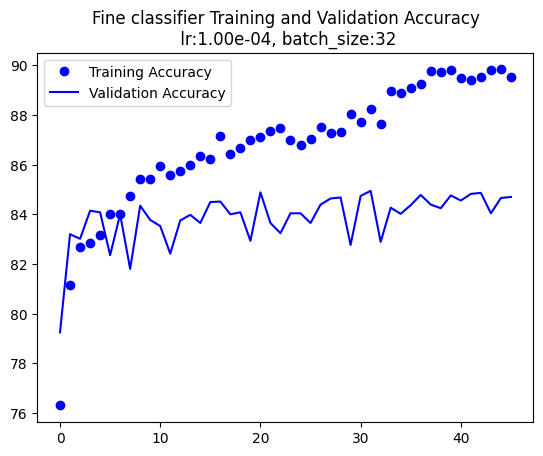


epoch: 46
training:accuracy:90.16%
test:accuracy:84.44%


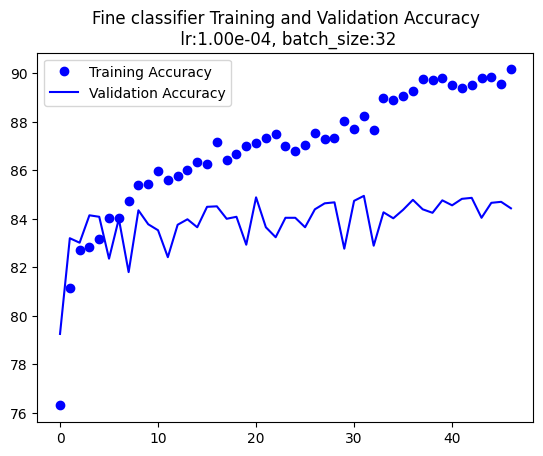


epoch: 47
training:accuracy:90.05%
test:accuracy:84.77%


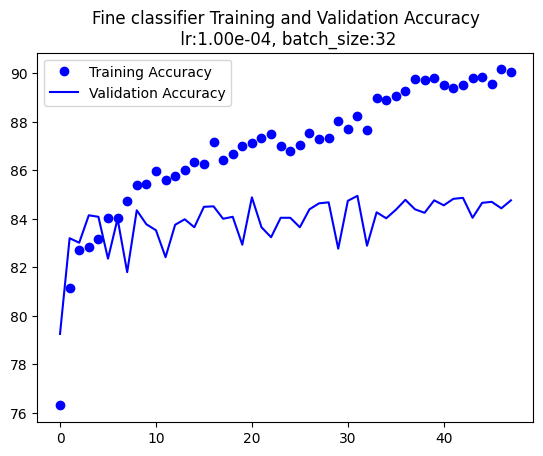


epoch: 48
training:accuracy:89.88%
test:accuracy:84.58%


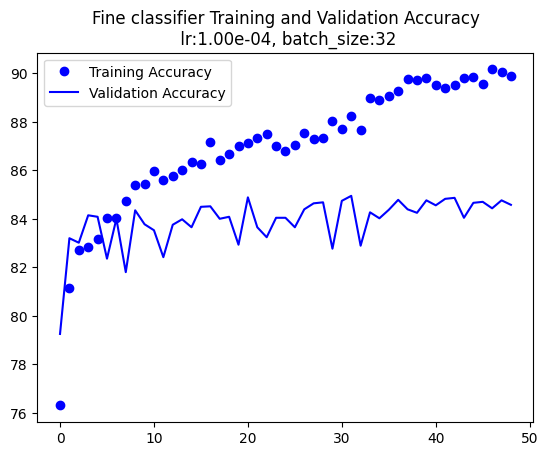


epoch: 49
training:accuracy:90.06%
test:accuracy:84.70%


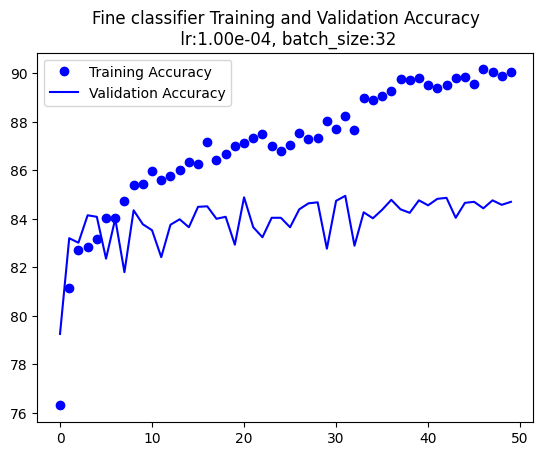

In [ ]:
fine_classes={
    '0':2,
    '1':2,
    '2':2,
}
# device = torch.device('cpu')
lr=0.001
epochs=50

fine_model=FineClassifier(fine_classes,coarse_model).to(device)
# if torch.cuda.is_available():
fine_model.to(device)

    # model = nn.DataParallel(model)
optimizer = optim.Adam(fine_model.parameters(), lr=lr,weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
train_step_fine(model=fine_model,num_epochs=epochs,dataloader_train=dataloader_train,dataloader_valid=dataloader_valid)

In [ ]:
# torch.save(coarse_model, 'coarse model.pth')
torch.save(model, 'fine model.pth')
# fine_model = torch.load('fine model.pth')

files.download('/content/fine model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
num_parameters = sum(p.numel() for p in coarse_model.parameters())

print(f"Total number of parameters in coarse model: {num_parameters}")

num_parameters = sum(p.numel() for p in fine_model.parameters())

print(f"Total number of parameters in fine model: {num_parameters}")

Total number of parameters in coarse model: 570180
Total number of parameters in fine model: 25302


(24320, 48, 48)
imgs.shape=(19456, 48, 48),len(emotion_lbls)=19456,len(coarse_lbls)=19456,len(fine_lbls)=19456
imgs.shape=(4864, 48, 48),len(emotion_lbls)=4864,len(coarse_lbls)=4864,len(fine_lbls)=4864
0.77734375


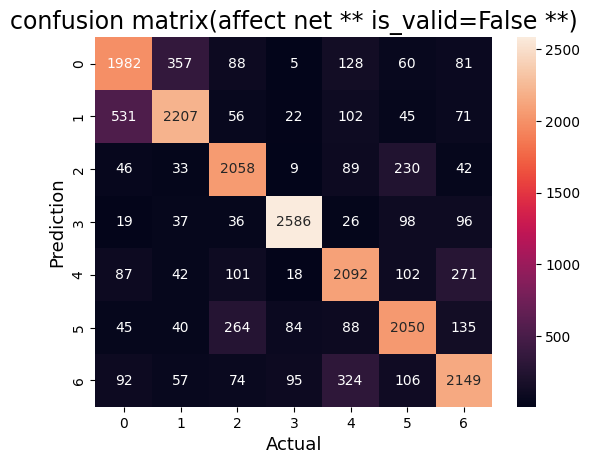

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
is_valid=False
dfs_names=['affect net']
dataloader_train , dataloader_valid = get_dataloaders(dfs_names,32)
if is_valid:
    dataloader=dataloader_valid
else:
    dataloader=dataloader_train

plot_name=f"{str(''.join(dfs_names))} ** {is_valid=} **"

coarse_fine_map={
    '0_0':0,
    '0_1':1,

    '1_0':4,
    '1_1':6,

    '2_0':3,
    '2_1':5,

    '3_0':2
    }
coarse_model = torch.load('coarse model.pth')
fine_model = torch.load('fine model.pth')
device = torch.device('cuda')
# fine_model=model
coarse_model.eval()
fine_model.eval()
n_correct=0
n_data=0
pred=[]
target=[]
for x,y_emotion,y_coarse,y_fine in dataloader:
  x,y_emotion,y_coarse,y_fine=x.to(device),y_emotion.to(device),y_coarse.to(device),y_fine.to(device)
  with torch.no_grad():
      coarse_output = coarse_model(x)
      fine_output=fine_model(x,coarse_output)
      coarse_fine=list(zip(coarse_output.argmax(axis=1).cpu().numpy(),fine_output.argmax(axis=1).cpu().numpy()))
      n_data+=len(y_coarse)
      for (c,f),ct,ft in zip(coarse_fine,
                             y_coarse.argmax(axis=1).cpu().numpy(),
                             y_fine.argmax(axis=1).cpu().numpy()):
        pred.append(coarse_fine_map[str(c)+'_'+str(f)])
        target.append(coarse_fine_map[str(ct)+'_'+str(ft)])

        # print(f'{c=},{f=},{ct=},{ft=}')
        if c==ct and f==ft:
          n_correct+=1

print(n_correct/n_data)
# print(f'{target=}')
# print(f'{pred=}')
plot_matrix(plot_name=f'confusion matrix({plot_name})',y_pred=np.array(pred),y=np.array(target))
files.download(f'/content/confusion matrix({plot_name}).jpg')
